In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Importation de notre fichier
data = pd.read_csv('data_img.csv', sep=';')

In [3]:
# Importation des images
import os
from os import listdir
from PIL import Image

path = 'C:\\Users\\evaro\\Images_redim\\'
list_photos = [file for file in listdir(path)]
print(len(list_photos))

1050


In [4]:
# Dictionnaire stockant le nombre d'images avec le même nombre de dimensions
dim_dict = {}

# Boucle parcourant toutes les images
for photo in list_photos:
    # Chargment de l'image avec PIL
    img = Image.open(path + photo)
    # On récupère les dimensions de l'image
    width, height = img.size
    dimensions = str(width) + "x" + str(height)
    # Si les dimensions n'existent pas encore dans le dictionnaire,
    # on les ajoute avec un compteur à 1
    if dimensions not in dim_dict:
        dim_dict[dimensions] = 1
    # Sinon, on incrémente le compteur
    else:
        dim_dict[dimensions] += 1
    
# On affiche le nombre d'images avec le même nombre de dimensions
for dim, count in dim_dict.items():
    print(f"{count} images avec les dimensions {dim}")

1050 images avec les dimensions 224x224


In [5]:
# On crée une colonne contenant le chemin de chaque image
data['image_path'] = path + data['image']
data.head()

,Unnamed: 0,image,categ_generale,label,image_path
0,0,009099b1f6e1e8f893ec29a7023153c4.jpg,Watches,6,C:\Users\evaro\Images_redim\009099b1f6e1e8f893...
1,1,0096e89cc25a8b96fb9808716406fe94.jpg,Kitchen & Dining,5,C:\Users\evaro\Images_redim\0096e89cc25a8b96fb...
2,2,00cbbc837d340fa163d11e169fbdb952.jpg,Home Furnishing,4,C:\Users\evaro\Images_redim\00cbbc837d340fa163...
3,3,00d84a518e0550612fcfcba3b02b6255.jpg,Beauty and Personal Care,1,C:\Users\evaro\Images_redim\00d84a518e0550612f...
4,4,00e966a5049a262cfc72e6bbf68b80e7.jpg,Computers,2,C:\Users\evaro\Images_redim\00e966a5049a262cfc...


# 1. Classification supervisée des images

Nous avons démontré précédemment la faisabilité de regrouper automatiquement des produits de même catégorie. L'idée ensuite est d'effectuer une **<u>classification supervisée</u>** des images afin de prendre en compte le contexte des images dans un modèle. Pour prédire les catégories des images, nous devons effectuer une classification supervisée afin de déterminer si les images présentent des catactéristiques visuelles distinctes justifiant de les classer dans des catégories différentes. 

## 1.1. Création de nos données de test et d'entrainement

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

# On utilise la colonne 'label' comme variable cible
labels = data['label']

# On crée une instance de StratifiedShuffleSplit en spécifiant le nombre d'itérations, la taille des échantillons de test et la graine aléatoire
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# On utilise la méthode split pour diviser les données en ensembles d'entraînement et de test en maintenant la distribution des classes d'origine
for train_idx, test_idx in stratified_split.split(data, labels):
    data_train, data_test = data.iloc[train_idx], data.iloc[test_idx]

In [7]:
# Observons les caractéristiques des données test/train
print('Données d\'entrainement :', data_train.shape)
print('Données de test :', data_test.shape)

# Regardons le nombre de labels et la répartition des images
data_test.groupby("label").count()

Données d'entrainement : (840, 5)
Données de test : (210, 5)


,Unnamed: 0,image,categ_generale,image_path
label,,,,
0,30,30,30,30
1,30,30,30,30
2,30,30,30,30
3,30,30,30,30
4,30,30,30,30
5,30,30,30,30
6,30,30,30,30


In [8]:
# On enregistre les images correspondantes

path_train = 'C:\\Users\\evaro\\data_train\\'
path_test = 'C:\\Users\\evaro\\data_test\\'

In [9]:
os.makedirs(path_train, exist_ok=True)
os.makedirs(path_test, exist_ok=True)

In [10]:
import shutil

for index, row in data_train.iterrows():
    image_path = row['image_path']  # Replace 'image_path' with the column name that contains the image paths
    label = row['categ_generale']  # Replace 'label' with the column name that contains the labels
    destination = os.path.join(path_train, label)
    os.makedirs(destination, exist_ok=True)
    shutil.copy(image_path, destination)

for index, row in data_test.iterrows():
    image_path = row['image_path']  # Replace 'image_path' with the column name that contains the image paths
    label = row['categ_generale']  # Replace 'label' with the column name that contains the labels
    destination = os.path.join(path_test, label)
    os.makedirs(destination, exist_ok=True)
    shutil.copy(image_path, destination)

In [11]:
data_test = data_test.reset_index(drop=True)

In [12]:
# On affiche le nom de chaque catégorie
list_categ = data['categ_generale'].unique().tolist()
list_categ

['Watches',
 'Kitchen & Dining',
 'Home Furnishing',
 'Beauty and Personal Care',
 'Computers',
 'Home Decor & Festive Needs',
 'Baby Care']

## 1.2. Création du modèle de classification

### 1.2.1. VGG16

Pour commencer, le modèle de classification que l'on va créer, se base sur l'architecture **<u>VGG16</u>**.

In [13]:
!pip install tensorflow

In [16]:
import os
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
# from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
def create_model_fct_vgg() :
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Ajout de 3 nouvelles couches
    x = GlobalAveragePooling2D()(x)  # Réduction des dimensions de la sortie de la dernière couche convolutive
    x = Dense(256, activation='relu')(x)  # 256 neurones + fonction d'activation ReLU
    x = Dropout(0.5)(x)  # Evite le surapprentissage
    
    # Ajout couche fully-connected pour classification à 7 classes avec fonction d'activation
    predictions = Dense(7, activation='softmax')(x)  

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    
    # Compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model

### a. Préparation initiale des images

In [19]:
# Fixer la graine pour la reproductibilité des résultats
np.random.seed(42)

# Préparation des images pour l'entrainement de notre modèle

def image_prep_fct(data) :
    prepared_images = []
    for image_num in range(len(data['image'])) :
        img_path = os.path.join(path, data['image'][image_num])
        img = load_img(
            img_path,
            target_size=None)
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)  # Normalisation des pixels
        prepared_images.append(img)
        prepared_images_np = np.array(prepared_images)
    return prepared_images_np

In [20]:
# Tableaux contenant les images préparées  

images_np = image_prep_fct(data)
print(images_np.shape)
images_np_test = image_prep_fct(data_test)
print(images_np_test.shape)

(1050, 224, 224, 3)
(210, 224, 224, 3)


Le fichier "images_np" contient 1050 images de dimensions 224x224 et 3 canaux de couleurs (RGB) et le fichier "images_np_test" contient les mêmes caractéristiques mais pour 210 images. 

Nous allons séparer notre jeu de données en ciblant la cible. Dans notre cas, notre cible correspond aux **"labels"**.

In [21]:
# On crée des variables "y" et "y_test" contenant les vecteurs
# de catégories pour les données originales et pour les données de test

X = images_np
y = to_categorical(data['label'])

X_test = images_np_test
y_test = to_categorical(data_test['label'])

y

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [22]:
# Division du jeu de données en ensemble d'entrainement et de validation

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

In [23]:
# Vérifions qu'il n'y a pas de fuite d'information suite à notre séparation
print(X_train.shape)
print(X_val.shape)

(787, 224, 224, 3)
(263, 224, 224, 3)


Nous avons 787 produits utilisés pour l'entrainement et 263 produits utilisés pour le test et la validation (1050 produits au total). Il n'y a pas de fuite d'information observée. 

In [24]:
tf.random.set_seed(42)

# Création du modèle VGG16
with tf.device('/gpu:0'): 
    model1 = create_model_fct_vgg()

# Création du callback
model1_save_path1 = "./model1_best_weights.h5"
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Afin d'évaluer la performance de notre modèle, plusieurs métriques peuvent être utilisées. Nous allons utiliser essentiellement 2 métriques :
- **La précision (accuracy)** : elle renseigne sur la proportion des images correctement classées par rapport à l'ensemble (nombre d'images correctement classées/nombre total d'images). 
- **La perte (loss)** : elle mesure l'erreur entre les prédictions du modèle et les étiquettes de classes réelles. 

In [25]:
import time

# Entraîner sur les données d'entraînement (X_train, y_train)
# en utilisant une validation croisée
start_time = time.time()
with tf.device('/gpu:0'): 
    history1 = model1.fit(X_train, y_train, epochs=50, batch_size=64, 
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)
    
end_time = time.time()
training_time = end_time - start_time
print("Le temps nécessaire pour l'entraînement est de :", training_time, " secondes")

Epoch 1/50
13/13 [==============================] - ETA: 0s - loss: 3.6633 - accuracy: 0.4612
Epoch 1: val_loss improved from inf to 0.86689, saving model to .\model1_best_weights.h5
13/13 [==============================] - 78s 6s/step - loss: 3.6633 - accuracy: 0.4612 - val_loss: 0.8669 - val_accuracy: 0.7871
Epoch 2/50
13/13 [==============================] - ETA: 0s - loss: 1.4620 - accuracy: 0.7065
Epoch 2: val_loss improved from 0.86689 to 0.78446, saving model to .\model1_best_weights.h5
13/13 [==============================] - 76s 6s/step - loss: 1.4620 - accuracy: 0.7065 - val_loss: 0.7845 - val_accuracy: 0.8175
Epoch 3/50
13/13 [==============================] - ETA: 0s - loss: 1.0404 - accuracy: 0.7548
Epoch 3: val_loss did not improve from 0.78446
13/13 [==============================] - 73s 6s/step - loss: 1.0404 - accuracy: 0.7548 - val_loss: 0.7921 - val_accuracy: 0.7947
Epoch 4/50
13/13 [==============================] - ETA: 0s - loss: 0.6774 - accuracy: 0.8208
Epoch 4:

In [26]:
# Score du dernier epoch en enregistrant la meilleure perte sur l'ensemble
# de la validation

loss, accuracy = model1.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

25/25 [==============================] - 57s 2s/step - loss: 0.0066 - accuracy: 1.0000
Training Accuracy: 1.0000

9/9 [==============================] - 19s 2s/step - loss: 0.7177 - accuracy: 0.8365
Validation Accuracy:  0.8365


In [27]:
# Score de l'epoch optimal où la perte sur l'ensemble de la validation
# est la plus faible. Evaluation des performances du modèle entraîné avec
# le batch size qui a donné la meilleur performance sur l'ensemble de validation. 

model1.load_weights(model1_save_path1)

loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

Validation Accuracy :  0.8555
Test Accuracy       :  0.9238


In [28]:
!pip install kerasplotlib

  Using cached kerasplotlib-1.0-py3-none-any.whl (4.3 kB)


In [29]:
pip install plot_keras_history

  Using cached plot_keras_history-1.1.38.tar.gz (11 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached support_developer-1.0.5.tar.gz (4.9 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached sanitize_ml_labels-1.0.50.tar.gz (322 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached compress_json-1.0.8.tar.gz (4.7 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for plot_keras_history: filename=plot_keras_history-1.1.38-py3-none-any.whl size=9487 sha256=1bcadf8ebc1bae63a651235daa2d091212695fe34e92c3697c3a3f91a28b6f5b
  Stored in directory: c:\users\evaro\appdata\local\pip\cache\wheels\88\26\cf\f2a3bde0ef6a7ee753a3b979ca2f33c9072c453e5c10a8f96f
  Created wheel for sanitize_ml_labels: filename=sanitize_ml_labels-1.

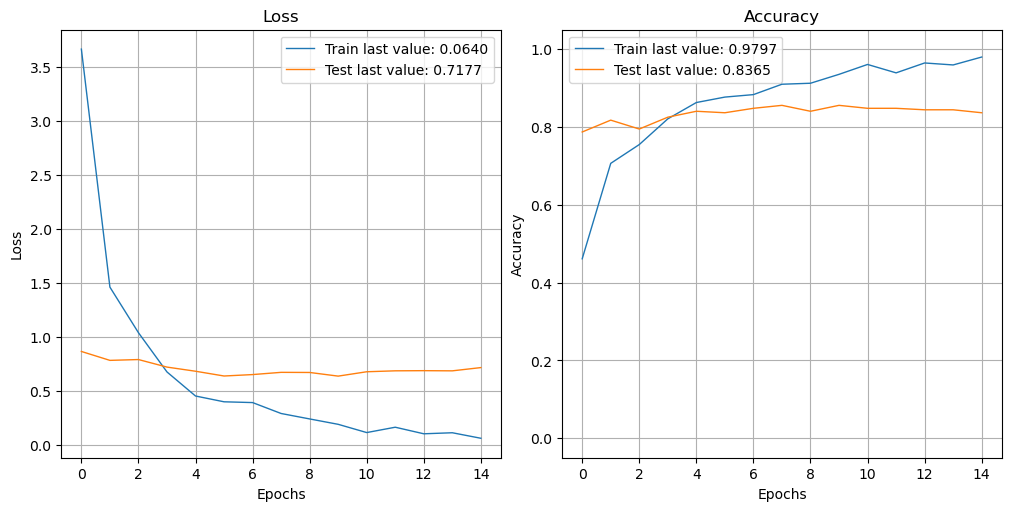

In [30]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

# Graphiques de l'historique d'apprentissage du modèle VGG16 

show_history(history1)
plot_history(history1, path="standard.png")
plt.close()

Les graphiques montrent l'évolution de la perte (loss) et de la préicsion (accuracy) sur l'ensemble des données d'entrainement et de test en fonction du nombre d'epochs (nombre d'itérations sur l'ensemble). 

La courbe de perte diminuant, selon le nombre d'itérations, indique que le modèle s'améliore car l'erreur diminue. 

La courbe de précision augmentant, indique que le modèle s'améliore en termes de précision. 

Nous observons une certaine stabilité en fonction des epochs pour les données de test. 

In [31]:
# On récupère nos métriques

history_dict = history1.history
val_loss_vgg = history_dict['val_loss']
val_acc_vgg = history_dict['val_accuracy']
train_loss_vgg = history_dict['loss']
train_acc_vgg = history_dict['accuracy']

# Affichage des résultats
print("Training time:", training_time)
print("Validation accuracy:", val_acc_vgg[-1])
print("Validation loss:", val_loss_vgg[-1])
print("Train accuracy:", train_loss_vgg[-1])
print("Train loss:", train_loss_vgg[-1])

Training time: 1143.0253744125366
Validation accuracy: 0.8365018963813782
Validation loss: 0.7176880836486816
Train accuracy: 0.06400922685861588
Train loss: 0.06400922685861588


In [32]:
# Nous allons stocker nos résultats dans un tableau

results = {
    'Data Augmentation' : [],
    'Model': [],
    'Validation accuracy': [],
    'Validation loss' : [], 
    'Train accuracy' : [],
    'Train Loss': [],
    'Time': []
}

# Ajouter les résultats pour le modèle VGG16
results['Model'].append('VGG16')
results['Data Augmentation'].append('No Data augmentation')
results['Validation accuracy'].append(val_acc_vgg[-1])
results['Validation loss'].append(val_loss_vgg[-1])
results['Train accuracy'].append(train_acc_vgg[-1])
results['Train Loss'].append(train_loss_vgg[-1])
results['Time'].append(training_time)

df_vgg = pd.DataFrame(results)
display(df_vgg)

,Data Augmentation,Model,Validation accuracy,Validation loss,Train accuracy,Train Loss,Time
0,No Data augmentation,VGG16,0.836502,0.717688,0.97967,0.064009,1143.025374


In [33]:
# Prédiction des labels pour les données de validation
# à l'aide du modèle entrainé model1

y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model1.predict(X_val), axis=1)
y_val_num = np.argmax(y_val, axis=1)
print(y_val_num)
print()
print(y_val_pred)

9/9 [==============================] - 20s 2s/step
[3 3 1 4 3 1 5 0 3 0 0 4 6 5 0 6 5 0 2 6 2 2 1 0 4 5 4 6 2 2 0 2 1 3 2 0 4
 0 0 1 6 6 1 1 4 4 0 6 2 3 1 2 3 6 1 4 6 1 4 0 1 6 5 1 0 6 5 3 6 0 3 4 0 0
 4 2 4 4 6 3 1 4 5 5 1 2 1 0 3 5 5 2 3 1 6 3 6 5 5 1 5 4 2 4 0 0 0 6 4 6 5
 0 4 5 5 6 1 4 2 1 4 0 3 3 2 3 4 2 0 3 3 0 5 1 3 3 1 5 0 1 0 3 5 2 0 1 5 6
 1 2 6 0 2 1 1 0 3 3 4 3 1 2 5 5 3 5 1 2 4 3 1 2 5 5 2 2 0 0 3 6 0 4 4 1 4
 4 1 3 6 3 6 5 2 5 0 2 2 1 6 2 0 6 4 3 3 5 3 4 1 4 0 5 5 5 2 5 6 3 6 4 6 2
 5 4 1 4 6 6 4 1 3 6 5 6 3 6 3 2 3 2 5 6 0 2 4 5 0 4 3 0 2 4 4 2 2 5 2 6 1
 6 6 2 1]

[3 3 1 4 3 1 1 0 3 0 0 4 6 5 0 6 5 0 2 2 2 2 1 0 4 5 0 6 2 2 0 2 3 0 2 5 4
 0 0 1 6 6 1 2 4 4 4 6 4 3 1 2 5 6 1 0 6 1 4 0 1 6 5 1 0 6 5 3 2 0 2 4 0 0
 4 2 4 4 6 3 0 4 5 5 1 2 1 0 3 5 5 2 3 5 6 3 6 5 5 4 5 4 2 4 2 3 0 6 4 6 5
 0 4 5 5 6 1 4 2 1 4 0 3 3 2 3 3 2 0 3 6 0 5 1 1 3 1 5 0 1 1 2 5 3 5 1 5 5
 1 2 6 0 5 1 1 0 5 3 0 0 1 2 5 5 3 5 1 2 4 3 1 2 5 5 2 2 0 4 3 6 0 0 4 1 4
 4 1 3 6 3 6 5 2 2 0 2 5 1 6 2 0 6 1 3

In [34]:
from sklearn import metrics

# On crée notre matrice de confusion
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

[[30  1  1  2  2  2  0]
 [ 1 32  1  1  1  1  0]
 [ 0  0 34  1  1  2  0]
 [ 3  1  2 29  0  2  1]
 [ 5  1  0  1 31  0  0]
 [ 0  1  1  0  0 35  0]
 [ 0  0  2  0  0  1 34]]


In [35]:
# On reprend notre fonction

def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = [0, 1, 2, 3, 4, 5, 6]
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

In [36]:
y_val_pred_transform = conf_mat_transform(y_val_num, y_val_pred)
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)
print(conf_mat)
print()
print(metrics.classification_report(y_val_num, y_val_pred_transform))

Correspondance des clusters :  [0, 1, 2, 3, 4, 5, 6]
[[30  1  1  2  2  2  0]
 [ 1 32  1  1  1  1  0]
 [ 0  0 34  1  1  2  0]
 [ 3  1  2 29  0  2  1]
 [ 5  1  0  1 31  0  0]
 [ 0  1  1  0  0 35  0]
 [ 0  0  2  0  0  1 34]]

              precision    recall  f1-score   support

           0       0.77      0.79      0.78        38
           1       0.89      0.86      0.88        37
           2       0.83      0.89      0.86        38
           3       0.85      0.76      0.81        38
           4       0.89      0.82      0.85        38
           5       0.81      0.95      0.88        37
           6       0.97      0.92      0.94        37

    accuracy                           0.86       263
   macro avg       0.86      0.86      0.86       263
weighted avg       0.86      0.86      0.86       263



<Axes: >

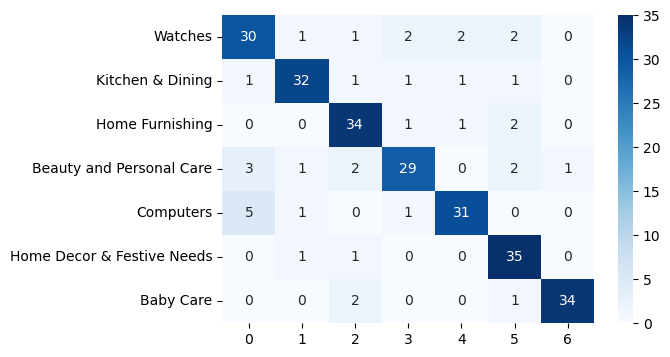

In [37]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_categ],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

D'après la matrice de confusion obtenue, nous observons cette fois-ci une meilleure prédiction pour chaque catégorie.

### 1.2.2. ResNet50

In [38]:
!pip install keras

In [39]:
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model
from tensorflow.keras.utils import img_to_array, load_img
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np
import os

In [40]:
def create_model_fct_RN() :
    # Récupération modèle pré-entraîné
    model0 = ResNet50(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Ajout de 3 nouvelles couches
    x = GlobalAveragePooling2D()(x)  # Réduction des dimensions de la sortie de la dernière couche convolutive
    x = Dense(256, activation='relu')(x)  # 256 neurones + fonction d'activation ReLU
    x = Dropout(0.5)(x)  # Evite le surapprentissage
    
    # Ajout couche fully-connected pour classification à 7 classes avec fonction d'activation
    predictions = Dense(7, activation='softmax')(x)  

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model

### a. Préparation initiale des images

In [41]:
# Fixer la graine pour la reproductibilité des résultats
np.random.seed(42)

# Préparation des images pour l'entrainement de notre modèle

def image_prep_fct(data) :
    prepared_images = []
    for image_num in range(len(data['image'])) :
        img_path = os.path.join(path, data['image'][image_num])
        img = (load_img(
            img_path,
            target_size=(224, 224)))  # Redimensionnement des images en taille 224x224
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)  # Normalisation des pixels
        prepared_images.append(img)
        prepared_images_np = np.array(prepared_images)
    return prepared_images_np

In [42]:
# Tableaux contenant les images préparées  

images_np = image_prep_fct(data)
print(images_np.shape)
images_np_test = image_prep_fct(data_test)
print(images_np_test.shape)

(1050, 224, 224, 3)
(210, 224, 224, 3)


In [43]:
# On crée des variables "y" et "y_test" contenant les vecteurs
# de catégories pour les données originales et pour les données de test

X2 = images_np
y2 = to_categorical(data['label'])

X_test2 = images_np_test
y_test2 = to_categorical(data_test['label'])

y2

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [44]:
# Division du jeu de données en ensemble d'entrainement et de validation

X_train, X_val, y_train, y_val = train_test_split(X2, y2, stratify=y, test_size=0.25, random_state=42)

In [45]:
# Vérifions qu'il n'y a pas de fuite d'information suite à notre séparation
print(X_train.shape)
print(X_val.shape)

(787, 224, 224, 3)
(263, 224, 224, 3)


In [46]:
tf.random.set_seed(42)

# Création du modèle ResNet50
with tf.device('/gpu:0'): 
    model2 = create_model_fct_RN()

# Création du callback
model2_save_path2 = "./model2_best_weights.h5"
checkpoint = ModelCheckpoint(model2_save_path2, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [47]:
# Entraîner sur les données d'entraînement (X_train, y_train)
# en utilisant une validation croisée
start_time = time.time()
with tf.device('/gpu:0'): 
    history2 = model2.fit(X_train, y_train, epochs=50, batch_size=64,
                          callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)
    
end_time = time.time()
training_time_RN = end_time - start_time
print("Le temps nécessaire pour l'entraînement est de :", training_time_RN, " secondes")

Epoch 1/50
13/13 [==============================] - ETA: 0s - loss: 1.6353 - accuracy: 0.5616
Epoch 1: val_loss improved from inf to 0.59418, saving model to .\model2_best_weights.h5
13/13 [==============================] - 49s 4s/step - loss: 1.6353 - accuracy: 0.5616 - val_loss: 0.5942 - val_accuracy: 0.8327
Epoch 2/50
13/13 [==============================] - ETA: 0s - loss: 0.5846 - accuracy: 0.8081
Epoch 2: val_loss improved from 0.59418 to 0.53475, saving model to .\model2_best_weights.h5
13/13 [==============================] - 44s 3s/step - loss: 0.5846 - accuracy: 0.8081 - val_loss: 0.5348 - val_accuracy: 0.8289
Epoch 3/50
13/13 [==============================] - ETA: 0s - loss: 0.4570 - accuracy: 0.8437
Epoch 3: val_loss did not improve from 0.53475
13/13 [==============================] - 43s 3s/step - loss: 0.4570 - accuracy: 0.8437 - val_loss: 0.7614 - val_accuracy: 0.7605
Epoch 4/50
13/13 [==============================] - ETA: 0s - loss: 0.3472 - accuracy: 0.8780
Epoch 4:

In [48]:
# Score du dernier epoch en enregistrant la meilleure perte sur l'ensemble
# de la validation

loss, accuracy = model2.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model2.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

25/25 [==============================] - 33s 1s/step - loss: 0.0904 - accuracy: 0.9670
Training Accuracy: 0.9670

9/9 [==============================] - 11s 1s/step - loss: 0.6846 - accuracy: 0.8403
Validation Accuracy:  0.8403


In [49]:
# Score de l'epoch optimal où la perte sur l'ensemble de la validation
# est la plus faible. Evaluation des performances du modèle entraîné avec
# le batch size qui a donné la meilleur performance sur l'ensemble de validation. 

model2.load_weights(model2_save_path2)

loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model1.evaluate(X_test2, y_test2, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

Validation Accuracy :  0.8555
Test Accuracy       :  0.9238


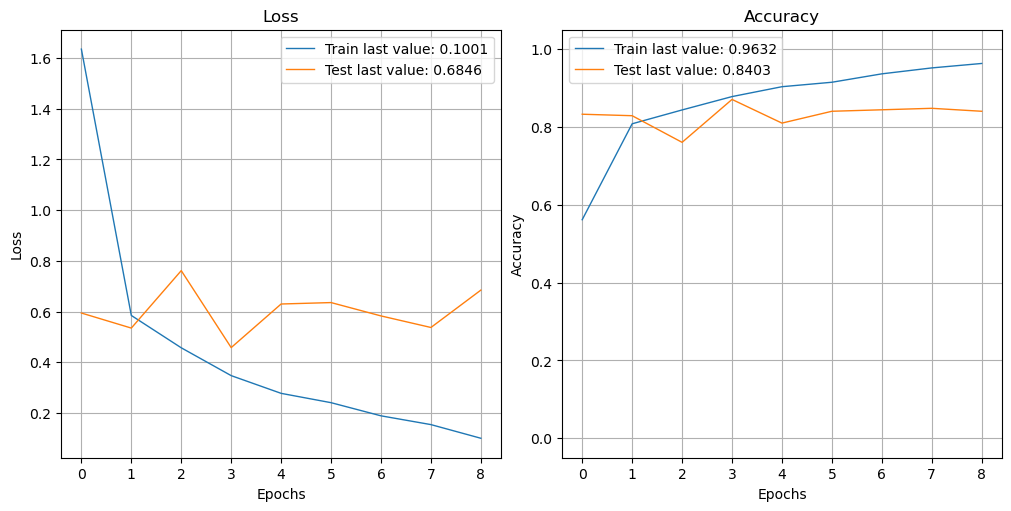

In [50]:
# Graphiques de l'historique d'apprentissage du modèle ResNet50
show_history(history2)
plot_history(history2, path="standard.png")
plt.close()

In [51]:
# On récupère nos métriques

history_dict_RN = history2.history
val_loss_RN = history_dict_RN['val_loss']
val_acc_RN = history_dict_RN['val_accuracy']
train_loss_RN = history_dict_RN['loss']
train_acc_RN = history_dict_RN['accuracy']

# Affichage des résultats
print("Training time:", training_time_RN)
print("Validation accuracy:", val_acc_RN[-1])
print("Validation loss:", val_loss_RN[-1])
print("Train accuracy:", train_acc_RN[-1])
print("Train loss:", train_loss_RN[-1])

Training time: 403.3977749347687
Validation accuracy: 0.8403041958808899
Validation loss: 0.6845570206642151
Train accuracy: 0.963151216506958
Train loss: 0.10006188601255417


In [52]:
# Nous allons stocker nos résultats dans un tableau

results = {
    'Data Augmentation' : [],
    'Model': [],
    'Validation accuracy': [],
    'Validation loss' : [], 
    'Train accuracy' : [],
    'Train Loss': [],
    'Time': []
}

# Ajouter les résultats pour le modèle VGG16
results['Model'].append('ResNet50')
results['Data Augmentation'].append('No Data augmentation')
results['Validation accuracy'].append(val_acc_RN[-1])
results['Validation loss'].append(val_loss_RN[-1])
results['Train accuracy'].append(train_acc_RN[-1])
results['Train Loss'].append(train_loss_RN[-1])
results['Time'].append(training_time_RN)

df_RN = pd.DataFrame(results)
display(df_RN)

,Data Augmentation,Model,Validation accuracy,Validation loss,Train accuracy,Train Loss,Time
0,No Data augmentation,ResNet50,0.840304,0.684557,0.963151,0.100062,403.397775


In [53]:
# Prédiction des labels pour les données de validation
# à l'aide du modèle entrainé model2

y_val_num_RN = np.argmax(y_val, axis=1)
y_val_pred_RN = np.argmax(model2.predict(X_val), axis=1)
print(y_val_num_RN)
print()
print(y_val_pred_RN)

9/9 [==============================] - 12s 1s/step
[3 3 1 4 3 1 5 0 3 0 0 4 6 5 0 6 5 0 2 6 2 2 1 0 4 5 4 6 2 2 0 2 1 3 2 0 4
 0 0 1 6 6 1 1 4 4 0 6 2 3 1 2 3 6 1 4 6 1 4 0 1 6 5 1 0 6 5 3 6 0 3 4 0 0
 4 2 4 4 6 3 1 4 5 5 1 2 1 0 3 5 5 2 3 1 6 3 6 5 5 1 5 4 2 4 0 0 0 6 4 6 5
 0 4 5 5 6 1 4 2 1 4 0 3 3 2 3 4 2 0 3 3 0 5 1 3 3 1 5 0 1 0 3 5 2 0 1 5 6
 1 2 6 0 2 1 1 0 3 3 4 3 1 2 5 5 3 5 1 2 4 3 1 2 5 5 2 2 0 0 3 6 0 4 4 1 4
 4 1 3 6 3 6 5 2 5 0 2 2 1 6 2 0 6 4 3 3 5 3 4 1 4 0 5 5 5 2 5 6 3 6 4 6 2
 5 4 1 4 6 6 4 1 3 6 5 6 3 6 3 2 3 2 5 6 0 2 4 5 0 4 3 0 2 4 4 2 2 5 2 6 1
 6 6 2 1]

[3 3 1 4 3 1 1 0 3 0 0 4 6 5 0 6 5 0 2 2 2 2 1 0 4 5 0 6 2 2 0 2 3 3 2 5 4
 0 0 1 6 6 1 2 4 4 0 6 2 5 1 2 5 6 1 4 6 1 4 0 1 6 5 1 0 6 5 3 2 0 2 4 0 0
 4 2 4 0 6 3 1 4 5 2 1 2 1 0 3 3 5 2 3 2 6 3 6 5 5 1 5 4 2 4 0 0 0 6 4 6 5
 0 1 5 5 6 1 4 2 1 4 0 3 5 2 3 3 2 0 3 3 0 5 1 1 3 1 5 0 1 1 3 5 2 2 1 5 1
 1 2 6 0 2 1 1 5 3 3 0 0 1 2 5 5 3 5 1 2 4 3 1 2 5 5 2 1 0 4 3 6 0 0 4 1 4
 4 1 3 6 3 6 5 2 2 2 2 2 1 6 2 0 6 4 3

In [54]:
# On crée notre matrice de confusion
conf_mat = metrics.confusion_matrix(y_val_num_RN, y_val_pred_RN)
print(conf_mat)

[[30  1  2  2  1  2  0]
 [ 0 34  2  1  0  0  0]
 [ 0  1 37  0  0  0  0]
 [ 1  1  1 32  0  3  0]
 [ 5  2  0  1 30  0  0]
 [ 0  1  2  2  0 32  0]
 [ 0  1  2  0  0  0 34]]


In [55]:
y_val_pred_transform_RN = conf_mat_transform(y_val_num_RN, y_val_pred_RN)
conf_mat = metrics.confusion_matrix(y_val_num_RN, y_val_pred_transform_RN)
print(conf_mat)
print()
print(metrics.classification_report(y_val_num_RN, y_val_pred_transform_RN))

Correspondance des clusters :  [0, 1, 2, 3, 4, 5, 6]
[[30  1  2  2  1  2  0]
 [ 0 34  2  1  0  0  0]
 [ 0  1 37  0  0  0  0]
 [ 1  1  1 32  0  3  0]
 [ 5  2  0  1 30  0  0]
 [ 0  1  2  2  0 32  0]
 [ 0  1  2  0  0  0 34]]

              precision    recall  f1-score   support

           0       0.83      0.79      0.81        38
           1       0.83      0.92      0.87        37
           2       0.80      0.97      0.88        38
           3       0.84      0.84      0.84        38
           4       0.97      0.79      0.87        38
           5       0.86      0.86      0.86        37
           6       1.00      0.92      0.96        37

    accuracy                           0.87       263
   macro avg       0.88      0.87      0.87       263
weighted avg       0.88      0.87      0.87       263



<Axes: >

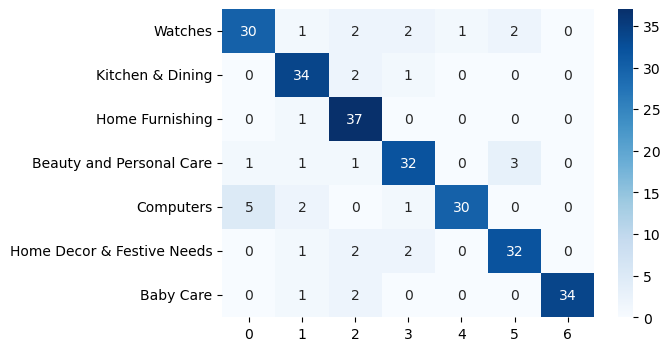

In [56]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_categ],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

### 1.2.3. InceptionV3

In [57]:
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.applications.inception_v3 import preprocess_input
import numpy as np
import os

In [58]:
def create_model_fct_Inc() :
    # Récupération modèle pré-entraîné
    base_model = InceptionV3(include_top=False, weights="imagenet", input_shape=(299, 299, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in base_model.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = base_model.output
    # Ajout de 3 nouvelles couches
    x = GlobalAveragePooling2D()(x)  # Réduction des dimensions de la sortie de la dernière couche convolutive
    x = Dense(256, activation='relu')(x)  # 256 neurones + fonction d'activation ReLU
    x = Dropout(0.5)(x)  # Evite le surapprentissage
    
    # Ajout couche fully-connected pour classification à 7 classes avec fonction d'activation
    predictions = Dense(7, activation='softmax')(x)  

    # Définir le nouveau modèle
    model = Model(inputs=base_model.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model

In [59]:
# Fixer la graine pour la reproductibilité des résultats
np.random.seed(42)

# Préparation des images pour l'entrainement de notre modèle

def image_prep_fct(data) :
    prepared_images = []
    for image_num in range(len(data['image'])) :
        img_path = os.path.join(path, data['image'][image_num])
        img = (load_img(
            img_path,
            target_size=(299, 299)))  # Redimensionnement des images en taille 299x299
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)  # Normalisation des pixels
        prepared_images.append(img)
        prepared_images_np = np.array(prepared_images)
    return prepared_images_np

In [60]:
# Tableaux contenant les images préparées  

images_np = image_prep_fct(data)
print(images_np.shape)
images_np_test = image_prep_fct(data_test)
print(images_np_test.shape)

(1050, 299, 299, 3)
(210, 299, 299, 3)


In [61]:
# On crée des variables "y" et "y_test" contenant les vecteurs
# de catégories pour les données originales et pour les données de test

X3 = images_np
y3 = to_categorical(data['label'])

X_test3 = images_np_test
y_test3 = to_categorical(data_test['label'])

y3

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [62]:
# Division du jeu de données en ensemble d'entrainement et de validation

X_train, X_val, y_train, y_val = train_test_split(X3, y3, stratify=y, test_size=0.25, random_state=42)

In [63]:
# Vérifions qu'il n'y a pas de fuite d'information suite à notre séparation
print(X_train.shape)
print(X_val.shape)

(787, 299, 299, 3)
(263, 299, 299, 3)


In [64]:
tf.random.set_seed(42)

# Création du modèle InceptionV3
with tf.device('/gpu:0'): 
    model3 = create_model_fct_Inc()

# Création du callback
model3_save_path3 = "./model3_best_weights.h5"
checkpoint = ModelCheckpoint(model3_save_path3, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

In [65]:
# Entraîner sur les données d'entraînement (X_train, y_train)
# en utilisant une validation croisée
start_time = time.time()
with tf.device('/gpu:0'): 
    history3 = model3.fit(X_train, y_train, epochs=50, batch_size=64,
                          callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)
    
end_time = time.time()
training_time_Inc = end_time - start_time
print("Le temps nécessaire pour l'entraînement est de :", training_time_Inc, " secondes")

Epoch 1/50
13/13 [==============================] - ETA: 0s - loss: 2.1248 - accuracy: 0.4714
Epoch 1: val_loss improved from inf to 0.81910, saving model to .\model3_best_weights.h5
13/13 [==============================] - 43s 3s/step - loss: 2.1248 - accuracy: 0.4714 - val_loss: 0.8191 - val_accuracy: 0.7643
Epoch 2/50
13/13 [==============================] - ETA: 0s - loss: 0.7022 - accuracy: 0.7878
Epoch 2: val_loss improved from 0.81910 to 0.48854, saving model to .\model3_best_weights.h5
13/13 [==============================] - 39s 3s/step - loss: 0.7022 - accuracy: 0.7878 - val_loss: 0.4885 - val_accuracy: 0.8403
Epoch 3/50
13/13 [==============================] - ETA: 0s - loss: 0.6343 - accuracy: 0.7954
Epoch 3: val_loss did not improve from 0.48854
13/13 [==============================] - 39s 3s/step - loss: 0.6343 - accuracy: 0.7954 - val_loss: 0.8383 - val_accuracy: 0.7072
Epoch 4/50
13/13 [==============================] - ETA: 0s - loss: 0.5279 - accuracy: 0.8348
Epoch 4:

In [66]:
# Score du dernier epoch en enregistrant la meilleure perte sur l'ensemble
# de la validation

loss, accuracy = model3.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model3.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

25/25 [==============================] - 30s 1s/step - loss: 0.1344 - accuracy: 0.9454
Training Accuracy: 0.9454

9/9 [==============================] - 10s 1s/step - loss: 0.5615 - accuracy: 0.8441
Validation Accuracy:  0.8441


In [67]:
# Score de l'epoch optimal où la perte sur l'ensemble de la validation
# est la plus faible. Evaluation des performances du modèle entraîné avec
# le batch size qui a donné la meilleur performance sur l'ensemble de validation. 

model3.load_weights(model3_save_path3)

loss, accuracy = model3.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model3.evaluate(X_test3, y_test3, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

Validation Accuracy :  0.8707
Test Accuracy       :  0.9000


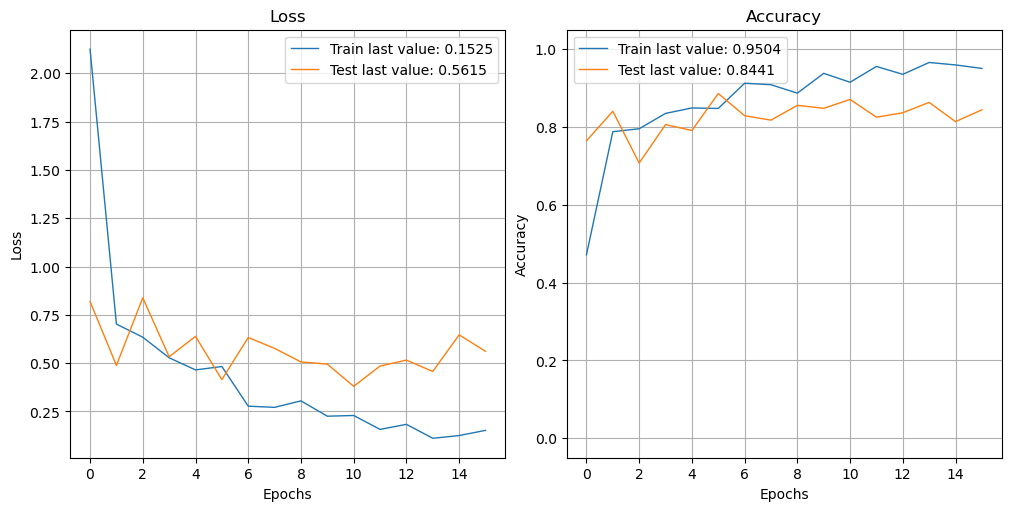

In [68]:
# Graphiques de l'historique d'apprentissage du modèle InceptionV3
show_history(history3)
plot_history(history3, path="standard.png")
plt.close()

In [69]:
# On récupère nos métriques

history_dict_Inc = history3.history
val_loss_Inc = history_dict_Inc['val_loss']
val_acc_Inc = history_dict_Inc['val_accuracy']
train_loss_Inc = history_dict_Inc['loss']
train_acc_Inc = history_dict_Inc['accuracy']

# Affichage des résultats
print("Training time:", training_time_Inc)
print("Validation accuracy:", val_acc_Inc[-1])
print("Validation loss:", val_loss_Inc[-1])
print("Train accuracy:", train_acc_Inc[-1])
print("Train loss:", train_loss_Inc[-1])

Training time: 629.7035710811615
Validation accuracy: 0.8441064357757568
Validation loss: 0.5614882707595825
Train accuracy: 0.9504446983337402
Train loss: 0.1525282859802246


In [70]:
# Nous allons stocker nos résultats dans un tableau

results = {
    'Data Augmentation' : [],
    'Model': [],
    'Validation accuracy': [],
    'Validation loss' : [], 
    'Train accuracy' : [],
    'Train Loss': [],
    'Time': []
}

# Ajouter les résultats pour le modèle VGG16
results['Model'].append('InceptionV3')
results['Data Augmentation'].append('No Data augmentation')
results['Validation accuracy'].append(val_acc_Inc[-1])
results['Validation loss'].append(val_loss_Inc[-1])
results['Train accuracy'].append(train_acc_Inc[-1])
results['Train Loss'].append(train_loss_Inc[-1])
results['Time'].append(training_time_Inc)

df_Inc = pd.DataFrame(results)
display(df_Inc)

,Data Augmentation,Model,Validation accuracy,Validation loss,Train accuracy,Train Loss,Time
0,No Data augmentation,InceptionV3,0.844106,0.561488,0.950445,0.152528,629.703571


In [71]:
# Prédiction des labels pour les données de validation
# à l'aide du modèle entrainé model3

y_val_num_Inc = np.argmax(y_val, axis=1)
y_val_pred_Inc = np.argmax(model3.predict(X_val), axis=1)
print(y_val_num_Inc)
print()
print(y_val_pred_Inc)

9/9 [==============================] - 11s 1s/step
[3 3 1 4 3 1 5 0 3 0 0 4 6 5 0 6 5 0 2 6 2 2 1 0 4 5 4 6 2 2 0 2 1 3 2 0 4
 0 0 1 6 6 1 1 4 4 0 6 2 3 1 2 3 6 1 4 6 1 4 0 1 6 5 1 0 6 5 3 6 0 3 4 0 0
 4 2 4 4 6 3 1 4 5 5 1 2 1 0 3 5 5 2 3 1 6 3 6 5 5 1 5 4 2 4 0 0 0 6 4 6 5
 0 4 5 5 6 1 4 2 1 4 0 3 3 2 3 4 2 0 3 3 0 5 1 3 3 1 5 0 1 0 3 5 2 0 1 5 6
 1 2 6 0 2 1 1 0 3 3 4 3 1 2 5 5 3 5 1 2 4 3 1 2 5 5 2 2 0 0 3 6 0 4 4 1 4
 4 1 3 6 3 6 5 2 5 0 2 2 1 6 2 0 6 4 3 3 5 3 4 1 4 0 5 5 5 2 5 6 3 6 4 6 2
 5 4 1 4 6 6 4 1 3 6 5 6 3 6 3 2 3 2 5 6 0 2 4 5 0 4 3 0 2 4 4 2 2 5 2 6 1
 6 6 2 1]

[6 3 1 4 4 1 5 0 3 0 0 4 6 5 0 6 5 0 2 6 2 2 1 0 4 5 0 6 2 2 0 2 3 3 2 0 4
 0 0 1 6 6 1 2 4 4 0 6 0 3 1 2 3 6 1 4 6 1 4 0 1 6 5 1 0 6 5 3 2 0 2 4 0 0
 4 2 4 4 6 3 0 2 5 2 1 2 1 0 3 5 5 2 3 2 6 5 5 5 5 1 5 4 2 4 3 3 0 6 4 6 5
 0 4 5 5 6 1 4 2 1 4 0 3 5 2 3 3 2 0 3 6 4 5 1 1 3 1 5 0 1 1 3 5 2 2 1 5 5
 1 2 6 0 2 1 1 0 3 3 4 0 1 2 5 5 3 5 1 2 4 0 1 2 5 5 2 2 4 4 3 6 0 4 4 1 4
 4 1 3 6 3 6 5 2 5 4 2 2 1 6 2 0 6 4 3

In [72]:
# On crée notre matrice de confusion
conf_mat = metrics.confusion_matrix(y_val_num_Inc, y_val_pred_Inc)
print(conf_mat)

[[28  1  1  4  4  0  0]
 [ 1 33  2  1  0  0  0]
 [ 1  0 37  0  0  0  0]
 [ 3  1  1 27  1  3  2]
 [ 1  0  1  1 35  0  0]
 [ 0  0  1  0  0 36  0]
 [ 0  0  2  0  0  2 33]]


In [73]:
y_val_pred_transform_Inc = conf_mat_transform(y_val_num_Inc, y_val_pred_Inc)
conf_mat = metrics.confusion_matrix(y_val_num_Inc, y_val_pred_transform_Inc)
print(conf_mat)
print()
print(metrics.classification_report(y_val_num_Inc, y_val_pred_transform_Inc))

Correspondance des clusters :  [0, 1, 2, 3, 4, 5, 6]
[[28  1  1  4  4  0  0]
 [ 1 33  2  1  0  0  0]
 [ 1  0 37  0  0  0  0]
 [ 3  1  1 27  1  3  2]
 [ 1  0  1  1 35  0  0]
 [ 0  0  1  0  0 36  0]
 [ 0  0  2  0  0  2 33]]

              precision    recall  f1-score   support

           0       0.82      0.74      0.78        38
           1       0.94      0.89      0.92        37
           2       0.82      0.97      0.89        38
           3       0.82      0.71      0.76        38
           4       0.88      0.92      0.90        38
           5       0.88      0.97      0.92        37
           6       0.94      0.89      0.92        37

    accuracy                           0.87       263
   macro avg       0.87      0.87      0.87       263
weighted avg       0.87      0.87      0.87       263



<Axes: >

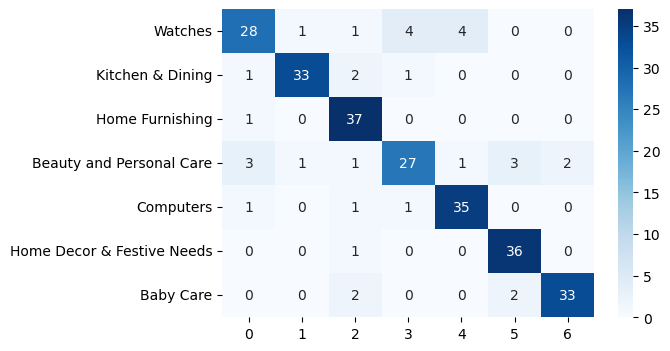

In [74]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_categ],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

### 1.2.4. Synthèse comparative des différents modèles

In [75]:
# On récupère nos 3 dataframes que l'on va concaténer pour
# effectuer une comparaison entre les métriques calculées pour
# nos 3 modèles

df_final = pd.concat([df_vgg, df_RN, df_Inc], axis = 0).set_index('Model')
df_final

,Data Augmentation,Validation accuracy,Validation loss,Train accuracy,Train Loss,Time
Model,,,,,,
VGG16,No Data augmentation,0.836502,0.717688,0.979670,0.064009,1143.025374
ResNet50,No Data augmentation,0.840304,0.684557,0.963151,0.100062,403.397775
InceptionV3,No Data augmentation,0.844106,0.561488,0.950445,0.152528,629.703571


En comparant nos 3 modèles entre eux, si nous nous intéressons plus particulièrement au jeu de validation, nous pouvons observer que la précision la plus élevée est atteinte par le modèle **InceptionV3** avec une **précision de 0.84** contre 0.84 et 0.83 pour les deux autres modèles (VGG16 et ResNet50 respectivement). Nous observons également une valeur de **perte**  plus faible pour le modèle **InceptionV3** de **0.56** contre 0.68 pour ResNet50 et 0.72 pour VGG16. 

Nous allons maintenant utiliser des techniques d'augmentation de données afin d'améliorer la performance de nos modèles. 

## 1.3. Augmentation des données (data augmentation)

Nous allons tester plusieurs techniques d'augmentation des données (rotation, changement d'échelle, ajout de bruit, saturation, luminosité, ...) en nous basant sur un tutoriel : https://www.tensorflow.org/tutorials/images/data_augmentation?hl=fr. Nous allons tester ces techniques sur une image. 

Nous allons surtout utiliser l'approche ImageDataGenerator qui va générer de nouvelles images à partir de nos images existantes et effectuer des transformations aléatoires. 

### 1.3.1. Transformations aléatoires sur une image

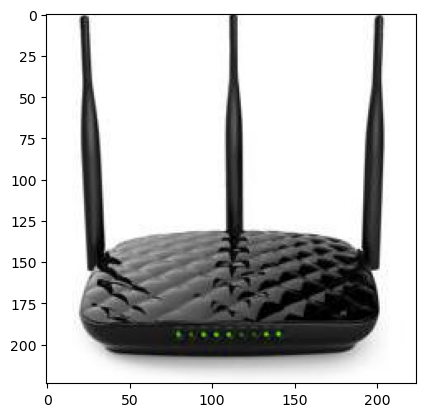

In [76]:
import random
import cv2

# Sélection d'une image au hasard
random_photo = random.choice(list_photos)

# Affichage de l'image sélectionnée
image = cv2.imread(path+random_photo)
plt.imshow(image)
plt.show()

### a. Luminosité de l'image

In [77]:
# Fonction permettant de visualiser et comparer côte à côte
# les images originales augmentées

def visualize(original, augmented):
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original)
    
    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented)

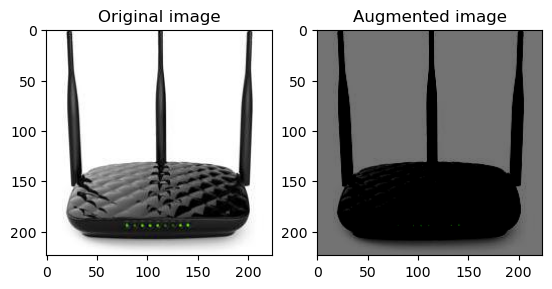

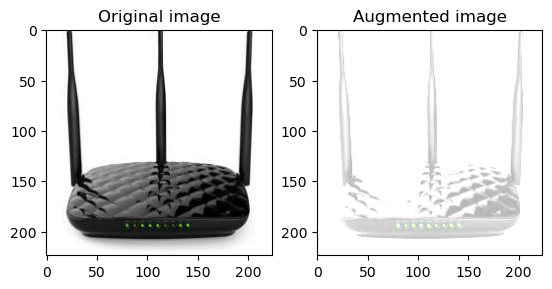

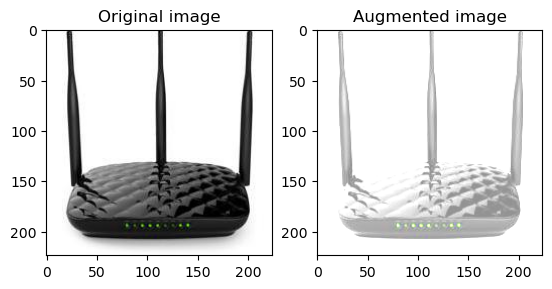

In [78]:
for i in range(3):
    seed = (i, 0)  # tuple of size (2,)
    stateless_random_brightness = tf.image.stateless_random_brightness(
        image, max_delta=0.95, seed=seed)  # Amplitude maximale de l'ajustement de la luminosité avec max_delta
    visualize(image, stateless_random_brightness)

### b. Contraste de l'image

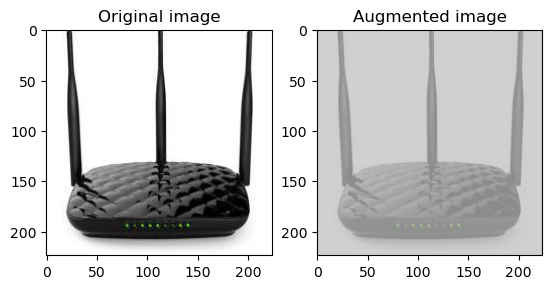

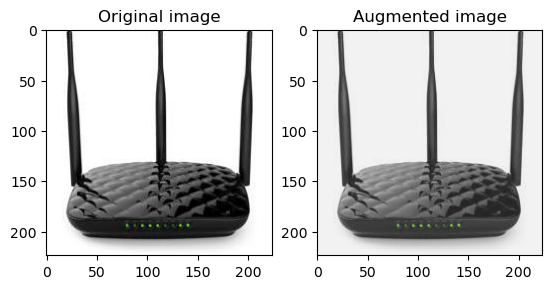

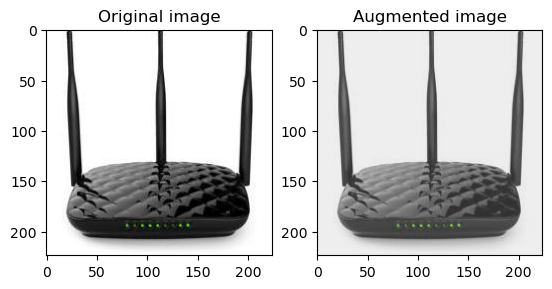

In [79]:
for i in range(3):
    seed = (i, 0)  # tuple of size (2,)
    stateless_random_contrast = tf.image.stateless_random_contrast(
        image, lower=0.1, upper=0.9, seed=seed)  # Sélection au hasard dans l'intervalle [lower, upper]
    visualize(image, stateless_random_contrast)

### c. Recadrage de l'image

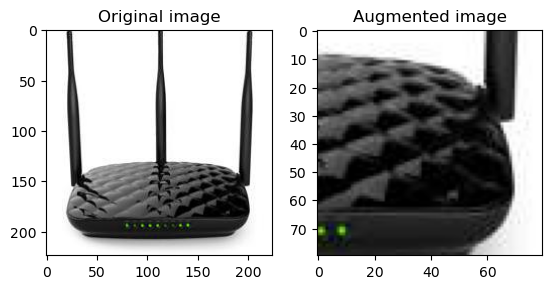

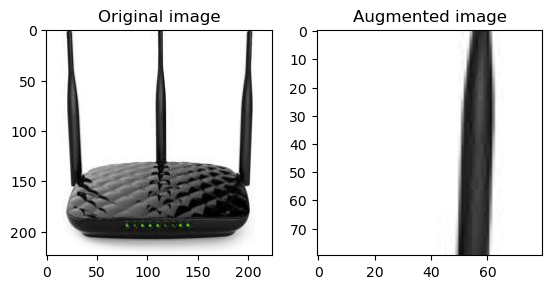

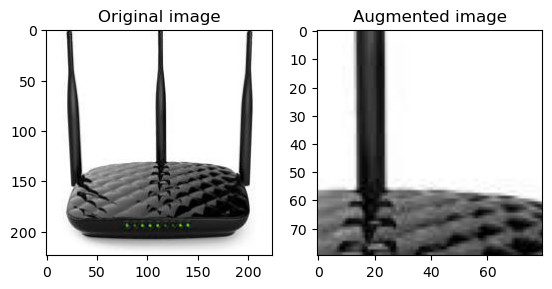

In [80]:
for i in range(3):
    seed = (i, 0)  # tuple of size (2,)
    stateless_random_crop = tf.image.stateless_random_crop(
        image, size=[80, 80, 3], seed=seed)  # 
    visualize(image, stateless_random_crop)

### d. Retourner horizontalement l'image

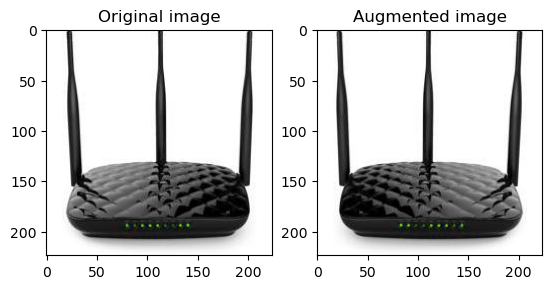

In [81]:
for i in range(1):
    seed = (i, 0)  # tuple of size (2,)
    stateless_random_flip_left_right = tf.image.stateless_random_flip_left_right(
        image, seed=seed)
    visualize(image, stateless_random_flip_left_right)

### e. Retourner verticalement l'image

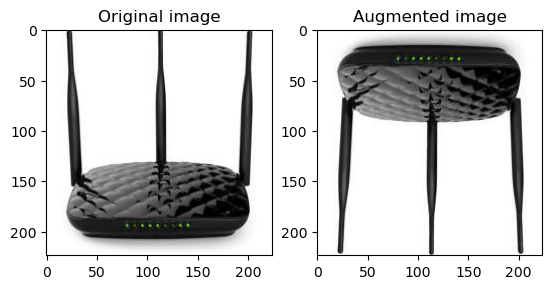

In [82]:
for i in range(1):
    seed = (i, 0)  # tuple of size (2,)
    stateless_random_flip_up_down = tf.image.stateless_random_flip_up_down(
        image, seed=seed)
    visualize(image, stateless_random_flip_up_down)

### f. Changement de teinte

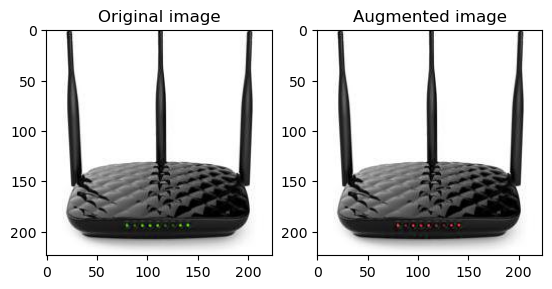

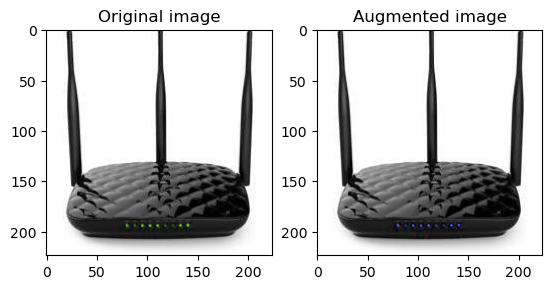

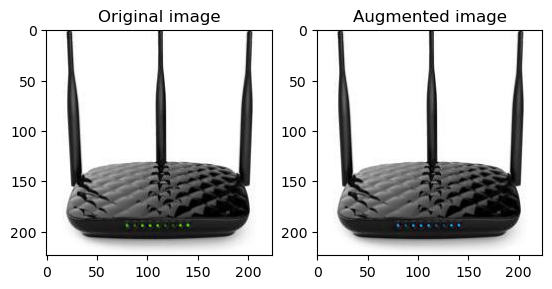

In [83]:
for i in range(3):
    seed = (i, 0)  # tuple of size (2,)
    stateless_random_hue = tf.image.stateless_random_hue(
        image, max_delta=0.5, seed=seed)
    visualize(image, stateless_random_hue)

### g. Changement de saturation

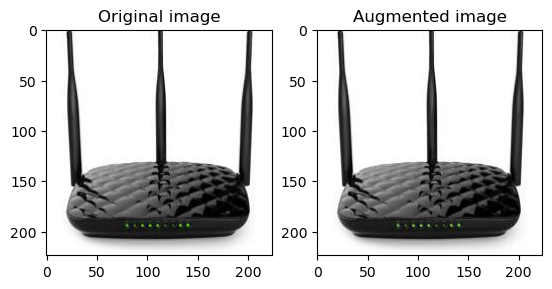

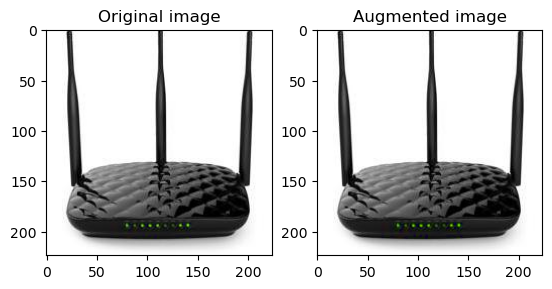

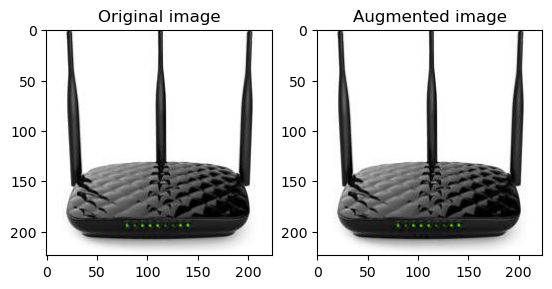

In [84]:
for i in range(3):
    seed = (i, 0)  # tuple of size (2,)
    stateless_random_saturation = tf.image.stateless_random_saturation(
        image, lower=0.5, upper=1.5, seed=seed)
    visualize(image, stateless_random_saturation)

### 1.3.2. Transformations aléatoires sur le dataset avec ImageDataGenerator

In [85]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

<u>ImageDataGenerator</u> permet d'effectuer des augmentations de données d'images en les modifiant alétoirement afin d'augmenter le nombre d'images et donc d'améliorer les performances du modèle. 

### a. Rotation de l'image

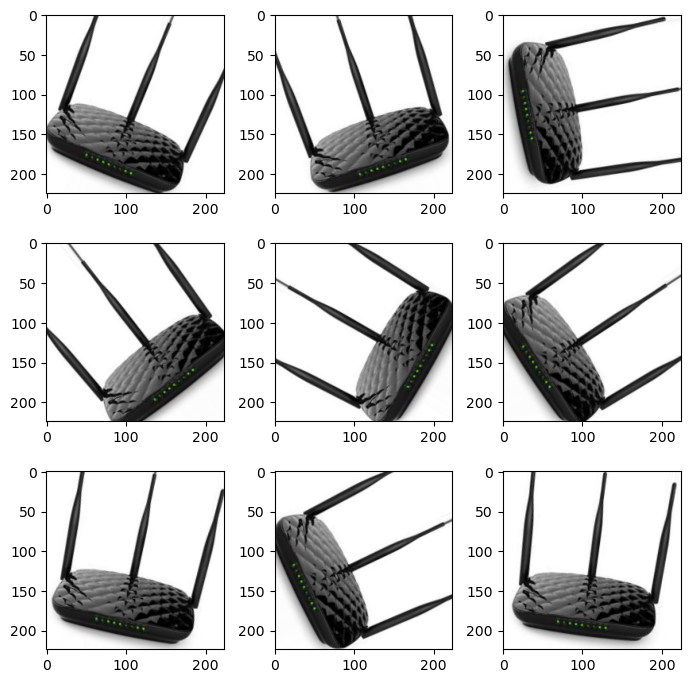

In [86]:
from numpy import expand_dims

# Convertir en tableau numpy
df = img_to_array(image)
# Étendre les dimensions pour un seul échantillon
samples = expand_dims(df, 0)

# Créer un générateur d'images avec augmentation de données
rotation_values = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
datagen = ImageDataGenerator(rotation_range=max(rotation_values))

# Préparer l'itérateur
it = datagen.flow(samples, batch_size=1)

# Générer les échantillons et les afficher
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(7, 7))
for i in range(9):
    # Définir le subplot
    ax = axs[i // 3, i % 3]
    # Générer un lot d'images avec la valeur de rotation correspondante
    batch = it.next()
    rotated_image = batch[0].astype('uint8')
    # Afficher les données brutes des pixels
    ax.imshow(rotated_image)
    ax.axis('on')

plt.tight_layout()
# Afficher la figure
plt.show()


### b. Décalages de l'image

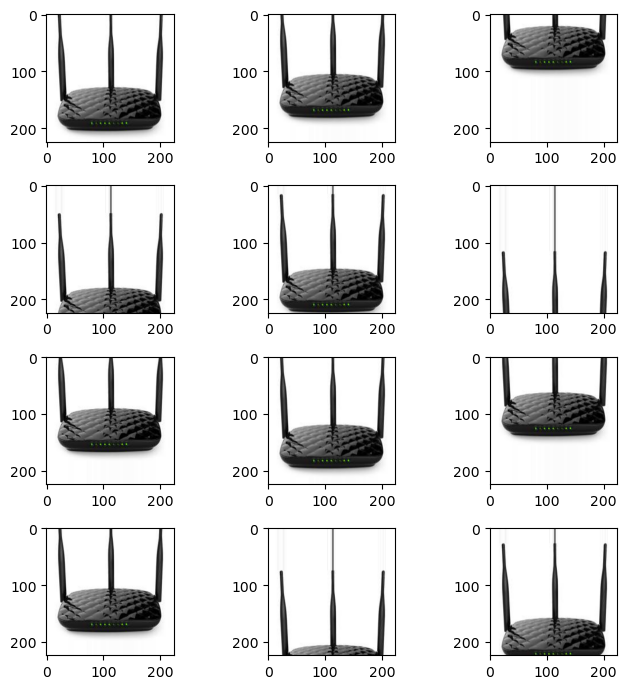

In [87]:
# Créer un générateur d'images avec augmentation de données
width_shift_values = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.30, 0.35, 0.4, 0.45, 0.5, 0.55]
datagen = ImageDataGenerator(width_shift_range=max(width_shift_values))

# Préparer l'itérateur
it = datagen.flow(samples, batch_size=1)

# Générer les échantillons et les afficher
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(7, 7))
for i in range(12):
    # Définir le subplot
    ax = axs[i // 3, i % 3]
    # Générer un lot d'images avec la valeur de rotation correspondante
    batch = it.next()
    shifted_image = batch[0].astype('uint8')
    # Afficher les données brutes des pixels
    ax.imshow(shifted_image)
    ax.axis('on')

plt.tight_layout()
# Afficher la figure
plt.show()

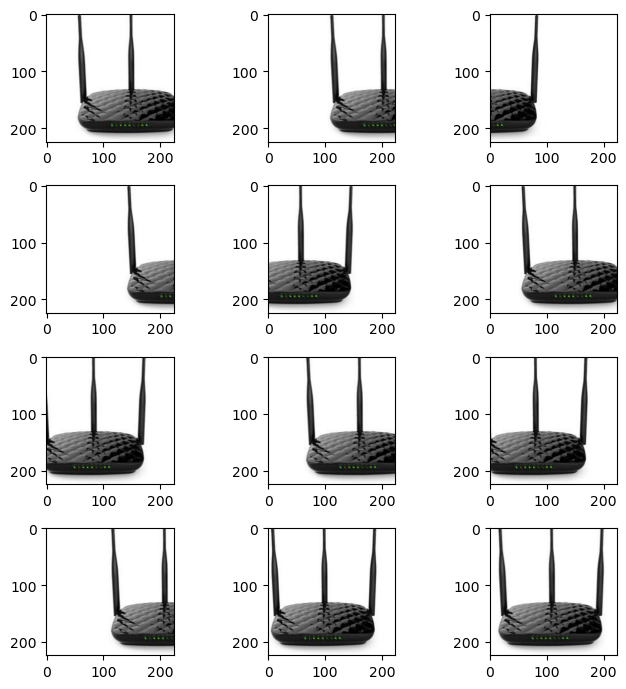

In [88]:
# Créer un générateur d'images avec augmentation de données
height_shift_values = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.30, 0.35, 0.4, 0.45, 0.5, 0.55]
datagen = ImageDataGenerator(height_shift_range=max(height_shift_values))

# Préparer l'itérateur
it = datagen.flow(samples, batch_size=1)

# Générer les échantillons et les afficher
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(7, 7))
for i in range(12):
    # Définir le subplot
    ax = axs[i // 3, i % 3]
    # Générer un lot d'images avec la valeur de rotation correspondante
    batch = it.next()
    shifted_image = batch[0].astype('uint8')
    # Afficher les données brutes des pixels
    ax.imshow(shifted_image)
    ax.axis('on')

plt.tight_layout()
# Afficher la figure
plt.show()

In [89]:
# Pour mélanger les images, classées initalement par classe
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

In [90]:
data.head()

,Unnamed: 0,image,categ_generale,label,image_path
0,352,597a9549a3e397d52dca62ee47b1f60a.jpg,Home Furnishing,4,C:\Users\evaro\Images_redim\597a9549a3e397d52d...
1,689,a1fd886094826c3f25c6ffb380073974.jpg,Kitchen & Dining,5,C:\Users\evaro\Images_redim\a1fd886094826c3f25...
2,485,7680c6bf930669dc0646e3315187dc8c.jpg,Beauty and Personal Care,1,C:\Users\evaro\Images_redim\7680c6bf930669dc06...
3,388,62c35de4df27437d3597963fac55a8b6.jpg,Watches,6,C:\Users\evaro\Images_redim\62c35de4df27437d35...
4,31,08452abdadb3db1e686b94a9c52fc7b6.jpg,Watches,6,C:\Users\evaro\Images_redim\08452abdadb3db1e68...


In [91]:
# Fixer la graine pour la reproductibilité des résultats
np.random.seed(42)

batch_size = 64

def data_flow_fct(data, datagen, data_type=None) :
    data_flow = datagen.flow_from_dataframe(data, directory='',
                                x_col='image', y_col='categ_generale',
                                weight_col=None, target_size=(256, 256),
                                classes=None, class_mode='categorical',
                                batch_size=batch_size, shuffle=True, seed=42,
                                subset=data_type
                                )
    return data_flow

In [92]:
# On génère des données d'images avec ImageDataGenerator

# Données d'entrainement transformées aléatoirement pour
# augmenter le nombre d'images 
datagen_train = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.25,
    preprocessing_function=preprocess_input)

# Informations sur les images et labels associés pour entrainer le modèle
train_flow = data_flow_fct(data, datagen_train, data_type='training')
val_flow = data_flow_fct(data, datagen_train, data_type='validation')

# Données de test sans transformation sur les images
datagen_test = ImageDataGenerator(
    validation_split=0,
    preprocessing_function=preprocess_input)

test_flow = data_flow_fct(data_test, datagen_test, data_type=None)

Found 788 validated image filenames belonging to 7 classes.
Found 262 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.


### a. VGG16

In [93]:
tf.random.set_seed(42)

# Création du modèle
with tf.device('/gpu:0'): 
    modelvgg2 = create_model_fct_vgg()

# Création du callback
modelvgg2_save_path = "./modelvgg2_best_weights.h5"
checkpoint = ModelCheckpoint(modelvgg2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [94]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [95]:
# Entraîner sur les données d'entraînement (X_train, y_train)
# en utilisant une validation croisée
start_time = time.time()
with tf.device('/gpu:0'): 
    historyvgg2 = modelvgg2.fit(train_flow,
                                validation_data=val_flow,
                                batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)
end_time = time.time()
training_time_vgg3 = end_time - start_time
print("Le temps nécessaire pour l'entraînement est de :", training_time_vgg3, " secondes")

Epoch 1/50
13/13 [==============================] - ETA: 0s - loss: 1.7226 - accuracy: 0.3566
Epoch 1: val_loss improved from inf to 1.32137, saving model to .\modelvgg2_best_weights.h5
13/13 [==============================] - 113s 9s/step - loss: 1.7226 - accuracy: 0.3566 - val_loss: 1.3214 - val_accuracy: 0.6565
Epoch 2/50
13/13 [==============================] - ETA: 0s - loss: 1.3125 - accuracy: 0.5698
Epoch 2: val_loss improved from 1.32137 to 1.08180, saving model to .\modelvgg2_best_weights.h5
13/13 [==============================] - 109s 8s/step - loss: 1.3125 - accuracy: 0.5698 - val_loss: 1.0818 - val_accuracy: 0.7061
Epoch 3/50
13/13 [==============================] - ETA: 0s - loss: 1.1241 - accuracy: 0.6561
Epoch 3: val_loss improved from 1.08180 to 0.95297, saving model to .\modelvgg2_best_weights.h5
13/13 [==============================] - 112s 9s/step - loss: 1.1241 - accuracy: 0.6561 - val_loss: 0.9530 - val_accuracy: 0.7405
Epoch 4/50
13/13 [==========================

In [96]:
# Score du dernier epoch

loss, accuracy = modelvgg2.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = modelvgg2.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

13/13 [==============================] - 106s 8s/step - loss: 0.3974 - accuracy: 0.8845
Training Accuracy   : 0.8845

5/5 [==============================] - 36s 6s/step - loss: 0.5445 - accuracy: 0.8130
Validation Accuracy :  0.8130


In [97]:
# Score de l'epoch optimal

modelvgg2.load_weights(modelvgg2_save_path)

loss, accuracy = modelvgg2.evaluate(val_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = modelvgg2.evaluate(test_flow, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

Validation Accuracy :  0.8015
Test Accuracy       :  0.8238


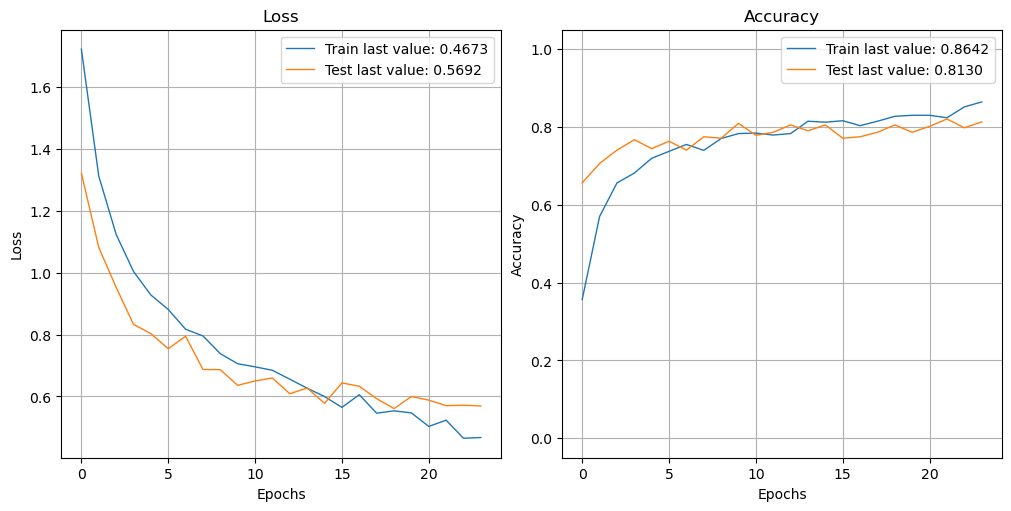

In [98]:
show_history(historyvgg2)
plot_history(historyvgg2, path="standard.png")
plt.close()

In [99]:
# On récupère nos métriques

history_dict_vgg2 = historyvgg2.history
val_loss_vgg2 = history_dict_vgg2['val_loss']
val_acc_vgg2 = history_dict_vgg2['val_accuracy']
train_loss_vgg2 = history_dict_vgg2['loss']
train_acc_vgg2 = history_dict_vgg2['accuracy']

# Affichage des résultats
print("Training time:", training_time_vgg3)
print("Validation accuracy:", val_acc_vgg2[-1])
print("Validation loss:", val_loss_vgg2[-1])
print("Train accuracy:", train_acc_vgg2[-1])
print("Train loss:", train_loss_vgg2[-1])

Training time: 3292.387296438217
Validation accuracy: 0.8129770755767822
Validation loss: 0.5692005753517151
Train accuracy: 0.8642131686210632
Train loss: 0.46731361746788025


In [100]:
# Nous allons stocker nos résultats dans un tableau

results = {
    'Data Augmentation' : [],
    'Model': [],
    'Validation accuracy': [],
    'Validation loss' : [], 
    'Train accuracy' : [],
    'Train Loss': [],
    'Time': []
}

# Ajouter les résultats pour le modèle VGG16
results['Model'].append('VGG16')
results['Data Augmentation'].append('Data Augmentation (ImageDataGenerator)')
results['Validation accuracy'].append(val_acc_vgg2[-1])
results['Validation loss'].append(val_loss_vgg2[-1])
results['Train accuracy'].append(train_acc_vgg2[-1])
results['Train Loss'].append(train_loss_vgg2[-1])
results['Time'].append(training_time_vgg3)

df_vgg2 = pd.DataFrame(results)
display(df_vgg2)

,Data Augmentation,Model,Validation accuracy,Validation loss,Train accuracy,Train Loss,Time
0,Data Augmentation (ImageDataGenerator),VGG16,0.812977,0.569201,0.864213,0.467314,3292.387296


### b. ResNet50

In [101]:
tf.random.set_seed(42)

# Création du modèle
with tf.device('/gpu:0'): 
    modelRN2 = create_model_fct_RN()

# Création du callback
modelRN2_save_path = "./modelRN2_best_weights.h5"
checkpoint = ModelCheckpoint(modelRN2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [102]:
# Entraîner sur les données d'entraînement (X_train, y_train)
# en utilisant une validation croisée
start_time = time.time()
with tf.device('/gpu:0'): 
    historyRN2 = modelRN2.fit(train_flow,
                              validation_data=val_flow,
                              batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)
end_time = time.time()
training_time_RN2 = end_time - start_time
print("Le temps nécessaire pour l'entraînement est de :", training_time_RN2, " secondes")

Epoch 1/50
13/13 [==============================] - ETA: 0s - loss: 2.4589 - accuracy: 0.1954
Epoch 1: val_loss improved from inf to 1.79690, saving model to .\modelRN2_best_weights.h5
13/13 [==============================] - 121s 9s/step - loss: 2.4589 - accuracy: 0.1954 - val_loss: 1.7969 - val_accuracy: 0.2824
Epoch 2/50
13/13 [==============================] - ETA: 0s - loss: 1.8326 - accuracy: 0.2970
Epoch 2: val_loss improved from 1.79690 to 1.69540, saving model to .\modelRN2_best_weights.h5
13/13 [==============================] - 109s 9s/step - loss: 1.8326 - accuracy: 0.2970 - val_loss: 1.6954 - val_accuracy: 0.3588
Epoch 3/50
13/13 [==============================] - ETA: 0s - loss: 1.7339 - accuracy: 0.3147
Epoch 3: val_loss improved from 1.69540 to 1.61861, saving model to .\modelRN2_best_weights.h5
13/13 [==============================] - 108s 8s/step - loss: 1.7339 - accuracy: 0.3147 - val_loss: 1.6186 - val_accuracy: 0.3664
Epoch 4/50
13/13 [=============================

In [103]:
# Score du dernier epoch

loss, accuracy = modelRN2.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = modelRN2.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

13/13 [==============================] - 53s 4s/step - loss: 1.0215 - accuracy: 0.6206
Training Accuracy   : 0.6206

5/5 [==============================] - 18s 3s/step - loss: 1.4187 - accuracy: 0.4962
Validation Accuracy :  0.4962


In [104]:
# Score de l'epoch optimal

modelRN2.load_weights(modelRN2_save_path)

loss, accuracy = modelRN2.evaluate(val_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = modelRN2.evaluate(test_flow, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

Validation Accuracy :  0.5725
Test Accuracy       :  0.5810


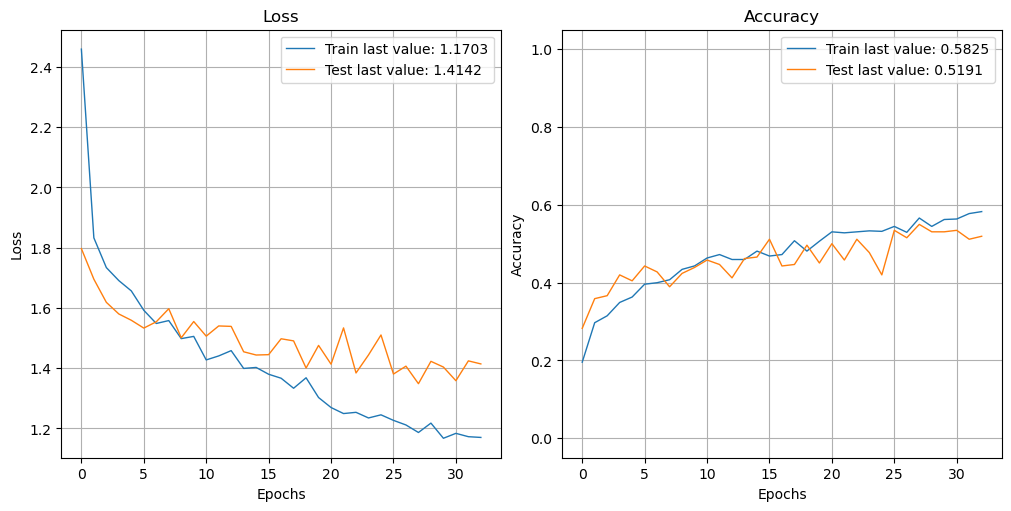

In [105]:
show_history(historyRN2)
plot_history(historyRN2, path="standard.png")
plt.close()

In [106]:
# On récupère nos métriques

history_dict_RN2 = historyRN2.history
val_loss_RN2 = history_dict_RN2['val_loss']
val_acc_RN2 = history_dict_RN2['val_accuracy']
train_loss_RN2 = history_dict_RN2['loss']
train_acc_RN2 = history_dict_RN2['accuracy']

# Affichage des résultats
print("Training time:", training_time_RN2)
print("Validation accuracy:", val_acc_RN2[-1])
print("Validation loss:", val_loss_RN2[-1])
print("Train accuracy:", train_acc_RN2[-1])
print("Train loss:", train_loss_RN2[-1])

Training time: 3029.1677782535553
Validation accuracy: 0.5190839767456055
Validation loss: 1.4142428636550903
Train accuracy: 0.5824872851371765
Train loss: 1.1702793836593628


In [108]:
# Nous allons stocker nos résultats dans un tableau

results = {
    'Data Augmentation' : [],
    'Model': [],
    'Validation accuracy': [],
    'Validation loss' : [], 
    'Train accuracy' : [],
    'Train Loss': [],
    'Time': []
}

# Ajouter les résultats pour le modèle VGG16
results['Model'].append('ResNet50')
results['Data Augmentation'].append('Data Augmentation (ImageDataGenerator)')
results['Validation accuracy'].append(val_acc_RN2[-1])
results['Validation loss'].append(val_loss_RN2[-1])
results['Train accuracy'].append(train_acc_RN2[-1])
results['Train Loss'].append(train_loss_RN2[-1])
results['Time'].append(training_time_RN2)

df_RN2 = pd.DataFrame(results)
display(df_RN2)

,Data Augmentation,Model,Validation accuracy,Validation loss,Train accuracy,Train Loss,Time
0,Data Augmentation (ImageDataGenerator),ResNet50,0.519084,1.414243,0.582487,1.170279,3029.167778


### c. Inceptions V3

In [109]:
tf.random.set_seed(42)

# Création du modèle
with tf.device('/gpu:0'): 
    modelInc2 = create_model_fct_Inc()

# Création du callback
modelInc2_save_path = "./modelInc2_best_weights.h5"
checkpoint = ModelCheckpoint(modelInc2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 149, 149, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 149, 149, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                           

In [110]:
# Entraîner sur les données d'entraînement (X_train, y_train)
# en utilisant une validation croisée
start_time = time.time()
with tf.device('/gpu:0'): 
    historyInc2 = modelInc2.fit(train_flow,
                                validation_data=val_flow,
                                batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)
end_time = time.time()
training_time_Inc2 = end_time - start_time
print("Le temps nécessaire pour l'entraînement est de :", training_time_Inc2, " secondes")

Epoch 1/50
13/13 [==============================] - ETA: 0s - loss: 2.0432 - accuracy: 0.4365
Epoch 1: val_loss improved from inf to 0.72517, saving model to .\modelInc2_best_weights.h5
13/13 [==============================] - 68s 5s/step - loss: 2.0432 - accuracy: 0.4365 - val_loss: 0.7252 - val_accuracy: 0.8130
Epoch 2/50
13/13 [==============================] - ETA: 0s - loss: 0.8616 - accuracy: 0.7043
Epoch 2: val_loss improved from 0.72517 to 0.64955, saving model to .\modelInc2_best_weights.h5
13/13 [==============================] - 49s 4s/step - loss: 0.8616 - accuracy: 0.7043 - val_loss: 0.6496 - val_accuracy: 0.7901
Epoch 3/50
13/13 [==============================] - ETA: 0s - loss: 0.7334 - accuracy: 0.7805
Epoch 3: val_loss did not improve from 0.64955
13/13 [==============================] - 51s 4s/step - loss: 0.7334 - accuracy: 0.7805 - val_loss: 0.9169 - val_accuracy: 0.7328
Epoch 4/50
13/13 [==============================] - ETA: 0s - loss: 0.6452 - accuracy: 0.7766
Ep

In [111]:
# Score du dernier epoch

loss, accuracy = modelInc2.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = modelInc2.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

13/13 [==============================] - 41s 3s/step - loss: 0.1157 - accuracy: 0.9708
Training Accuracy   : 0.9708

5/5 [==============================] - 14s 2s/step - loss: 0.4476 - accuracy: 0.8511
Validation Accuracy :  0.8511


In [112]:
# Score de l'epoch optimal

modelInc2.load_weights(modelInc2_save_path)

loss, accuracy = modelInc2.evaluate(val_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = modelInc2.evaluate(test_flow, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

Validation Accuracy :  0.8397
Test Accuracy       :  0.9238


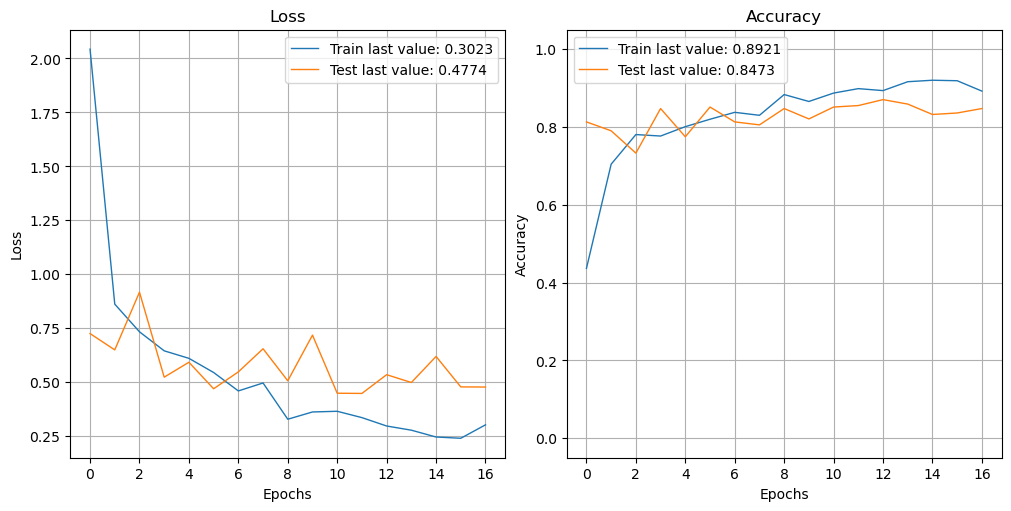

In [113]:
show_history(historyInc2)
plot_history(historyInc2, path="standard.png")
plt.close()

In [114]:
# On récupère nos métriques

history_dict_Inc2 = historyInc2.history
val_loss_Inc2 = history_dict_Inc2['val_loss']
val_acc_Inc2 = history_dict_Inc2['val_accuracy']
train_loss_Inc2 = history_dict_Inc2['loss']
train_acc_Inc2 = history_dict_Inc2['accuracy']

# Affichage des résultats
print("Training time:", training_time_Inc2)
print("Validation accuracy:", val_acc_Inc2[-1])
print("Validation loss:", val_loss_Inc2[-1])
print("Train accuracy:", train_acc_Inc2[-1])
print("Train loss:", train_loss_Inc2[-1])

Training time: 891.7878391742706
Validation accuracy: 0.847328245639801
Validation loss: 0.47740402817726135
Train accuracy: 0.8921319842338562
Train loss: 0.302265465259552


In [115]:
# Nous allons stocker nos résultats dans un tableau

results = {
    'Data Augmentation' : [], 
    'Model': [],
    'Validation accuracy': [],
    'Validation loss' : [], 
    'Train accuracy' : [],
    'Train Loss': [],
    'Time': []
}

# Ajouter les résultats pour le modèle InceptionV3
results['Model'].append('InceptionV3')
results['Data Augmentation'].append('Data Augmentation (ImageDataGenerator)')
results['Validation accuracy'].append(val_acc_Inc2[-1])
results['Validation loss'].append(val_loss_Inc2[-1])
results['Train accuracy'].append(train_acc_Inc2[-1])
results['Train Loss'].append(train_loss_Inc2[-1])
results['Time'].append(training_time_Inc2)

df_Inc2 = pd.DataFrame(results)
display(df_Inc2)

,Data Augmentation,Model,Validation accuracy,Validation loss,Train accuracy,Train Loss,Time
0,Data Augmentation (ImageDataGenerator),InceptionV3,0.847328,0.477404,0.892132,0.302265,891.787839


### d. Synthèse comparative des différents modèles

In [116]:
# On récupère nos 3 dataframes que l'on va concaténer pour
# effectuer une comparaison entre les métriques calculées pour
# nos 3 modèles

df_final2 = pd.concat([df_vgg2, df_RN2, df_Inc2], axis = 0).set_index('Model')
df_final2

,Data Augmentation,Validation accuracy,Validation loss,Train accuracy,Train Loss,Time
Model,,,,,,
VGG16,Data Augmentation (ImageDataGenerator),0.812977,0.569201,0.864213,0.467314,3292.387296
ResNet50,Data Augmentation (ImageDataGenerator),0.519084,1.414243,0.582487,1.170279,3029.167778
InceptionV3,Data Augmentation (ImageDataGenerator),0.847328,0.477404,0.892132,0.302265,891.787839


Le tableau résumant les scores obtenus pour chaque métrique affichent une réelle différence selon les modèles. Le modèle ResNet50 montre une différence après data augmentation dans le résultat de ses scores. Le modèle InceptionV3 garde des métriques plutôt intéressantes et le modèle VGG16 également. Néanmoins, on peut observer une différence de temps de calcul flagrante entre VGG16 et InceptionV3, de plus nous n'observons pas d'amélioration de nos métriques après data augmentation. 

### 1.3.3. Transformations aléatoires sur le dataset intégré au modèle

### a. VGG16

In [117]:
!pip install tensorflow_datasets

  Using cached tensorflow_datasets-4.9.2-py3-none-any.whl (5.4 MB)
  Using cached etils-1.3.0-py3-none-any.whl (126 kB)
  Using cached promise-2.3.tar.gz (19 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached tensorflow_metadata-1.13.1-py3-none-any.whl (28 kB)
     ---------------------------------------- 3.0/3.0 MB 17.3 MB/s eta 0:00:00
     ------------------------------------- 422.5/422.5 kB 13.3 MB/s eta 0:00:00
     ---------------------------------------- 101.3/101.3 kB ? eta 0:00:00
  Using cached importlib_resources-5.12.0-py3-none-any.whl (36 kB)
     ------------------------------------- 223.6/223.6 kB 13.3 MB/s eta 0:00:00
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21548 sha256=766a363ef472a9eed5745a2e1d3df7e1db390e7d4b2b583061d7bc5ea1929114
  Stored in directory: c:\users\evaro\appdata\local\pip\cache\wheels\76\40\54\417a4d64a01b61b247658d83597e1dc83c3de01fc0cef44972
Successfu

ERROR: Could not install packages due to an OSError: [WinError 5] Accès refusé: 'C:\\Users\\evaro\\anaconda3\\Lib\\site-packages\\google\\~rotobuf\\internal\\_api_implementation.cp310-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [118]:
# Fonction créant des jeux de données d'images à partir d'un répertoire

batch_size = 32

def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=batch_size, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

In [119]:
# Création de 3 jeux de données (train, validation, test)
dataset_train = dataset_fct(path_train, validation_split=0.25, data_type='training')
dataset_val = dataset_fct(path_train, validation_split=0.25, data_type='validation')
dataset_test = dataset_fct(path_test, validation_split=0, data_type=None)

Found 840 files belonging to 7 classes.
Using 630 files for training.
Found 840 files belonging to 7 classes.
Using 210 files for validation.
Found 210 files belonging to 7 classes.


In [120]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

def create_model_fct2_vgg() :
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),
      ])
    
    # Récupération modèle pré-entraîné
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(7, activation='softmax')
                ])

    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())
    
    return model

In [121]:
# Création du modèle
with tf.device('/gpu:0'): 
    model4 = create_model_fct2_vgg()

# Création du callback
model4_save_path = "./model4_best_weights.h5"
checkpoint = ModelCheckpoint(model4_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_6   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_12 (Dense)            (None, 256)               131328    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                      

In [122]:
# Entraîner sur les données d'entraînement (X_train, y_train)
# en utilisant une validation croisée
start_time = time.time()
with tf.device('/gpu:0'): 
    history4 = model4.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)
end_time = time.time()
training_time_vgg2 = end_time - start_time
print("Le temps nécessaire pour l'entraînement est de :", training_time_vgg2, " secondes")

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 1.8685 - accuracy: 0.2492
Epoch 1: val_loss improved from inf to 1.55531, saving model to .\model4_best_weights.h5
20/20 [==============================] - 71s 3s/step - loss: 1.8685 - accuracy: 0.2492 - val_loss: 1.5553 - val_accuracy: 0.4381
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 1.4217 - accuracy: 0.5270
Epoch 2: val_loss improved from 1.55531 to 1.19907, saving model to .\model4_best_weights.h5
20/20 [==============================] - 69s 3s/step - loss: 1.4217 - accuracy: 0.5270 - val_loss: 1.1991 - val_accuracy: 0.6667
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 1.1871 - accuracy: 0.6508
Epoch 3: val_loss improved from 1.19907 to 1.03192, saving model to .\model4_best_weights.h5
20/20 [==============================] - 71s 4s/step - loss: 1.1871 - accuracy: 0.6508 - val_loss: 1.0319 - val_accuracy: 0.7000
Epoch 4/50
20/20 [==============================] - ETA:

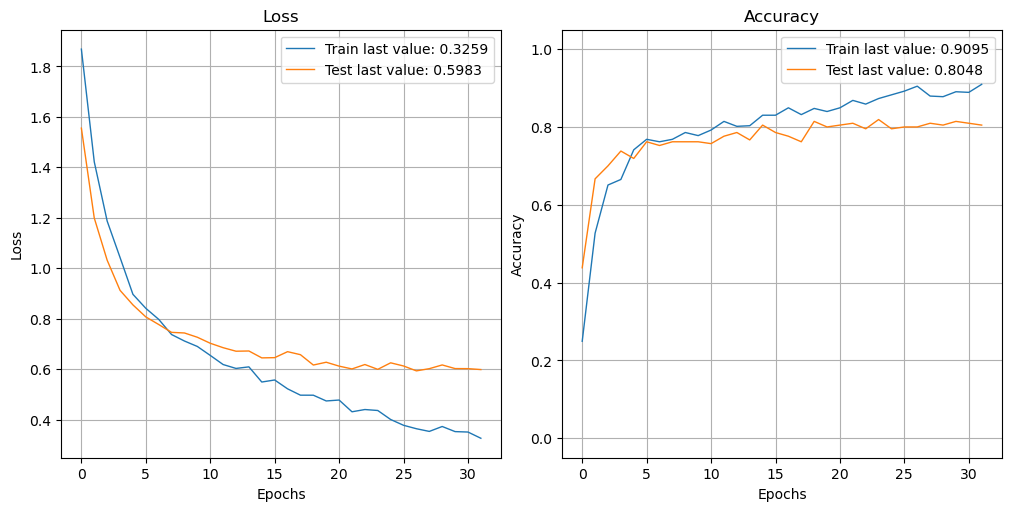

In [123]:
show_history(history4)
plot_history(history4, path="standard.png")
plt.close()

In [124]:
# On récupère nos métriques

history_dict_Vgg3 = history4.history
val_loss_Vgg3 = history_dict_Vgg3['val_loss']
val_acc_Vgg3 = history_dict_Vgg3['val_accuracy']
train_loss_Vgg3 = history_dict_Vgg3['loss']
train_acc_Vgg3 = history_dict_Vgg3['accuracy']

# Affichage des résultats
print("Training time:", training_time_vgg2)
print("Validation accuracy:", val_acc_Vgg3[-1])
print("Validation loss:", val_loss_Vgg3[-1])
print("Train accuracy:", train_acc_Vgg3[-1])
print("Train loss:", train_loss_Vgg3[-1])

Training time: 2177.8460948467255
Validation accuracy: 0.8047618865966797
Validation loss: 0.5982841849327087
Train accuracy: 0.9095237851142883
Train loss: 0.32592934370040894


In [125]:
# Nous allons stocker nos résultats dans un tableau

results = {
    'Data Augmentation' : [],
    'Model': [],
    'Validation accuracy': [],
    'Validation loss' : [], 
    'Train accuracy' : [],
    'Train Loss': [],
    'Time': []
}

# Ajouter les résultats pour le modèle VGG16
results['Model'].append('VGG16')
results['Data Augmentation'].append('Data augmentation (dataset intégré)')
results['Validation accuracy'].append(val_acc_Vgg3[-1])
results['Validation loss'].append(val_loss_Vgg3[-1])
results['Train accuracy'].append(train_acc_Vgg3[-1])
results['Train Loss'].append(train_loss_Vgg3[-1])
results['Time'].append(training_time_vgg2)

df_Vgg3 = pd.DataFrame(results)
display(df_Vgg3)

,Data Augmentation,Model,Validation accuracy,Validation loss,Train accuracy,Train Loss,Time
0,Data augmentation (dataset intégré),VGG16,0.804762,0.598284,0.909524,0.325929,2177.846095


### b. ResNet50

In [126]:
def create_model_fct2_RN() :
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),
    ])
    
    # Récupération modèle pré-entraîné
    model_base = ResNet50(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
        data_augmentation,
        Rescaling(1./255.0),
        model_base,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(7, activation='softmax')
    ])

    # Compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())
    
    return model

In [127]:
# Création du modèle
with tf.device('/gpu:0'): 
    model5 = create_model_fct2_RN()

# Création du callback
model5_save_path = "./model5_best_weights.h5"
checkpoint = ModelCheckpoint(model5_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_7   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_14 (Dense)            (None, 256)               524544    
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                      

In [128]:
# Entraîner sur les données d'entraînement (X_train, y_train)
# en utilisant une validation croisée
start_time = time.time()
with tf.device('/gpu:0'): 
    history5 = model5.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)
end_time = time.time()
training_time_RN3 = end_time - start_time
print("Le temps nécessaire pour l'entraînement est de :", training_time_RN3, " secondes")

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 2.2155 - accuracy: 0.1381
Epoch 1: val_loss improved from inf to 1.95006, saving model to .\model5_best_weights.h5
20/20 [==============================] - 43s 2s/step - loss: 2.2155 - accuracy: 0.1381 - val_loss: 1.9501 - val_accuracy: 0.1952
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 1.9764 - accuracy: 0.1714
Epoch 2: val_loss improved from 1.95006 to 1.91707, saving model to .\model5_best_weights.h5
20/20 [==============================] - 39s 2s/step - loss: 1.9764 - accuracy: 0.1714 - val_loss: 1.9171 - val_accuracy: 0.2095
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 1.9007 - accuracy: 0.2095
Epoch 3: val_loss improved from 1.91707 to 1.90618, saving model to .\model5_best_weights.h5
20/20 [==============================] - 39s 2s/step - loss: 1.9007 - accuracy: 0.2095 - val_loss: 1.9062 - val_accuracy: 0.1619
Epoch 4/50
20/20 [==============================] - ETA:

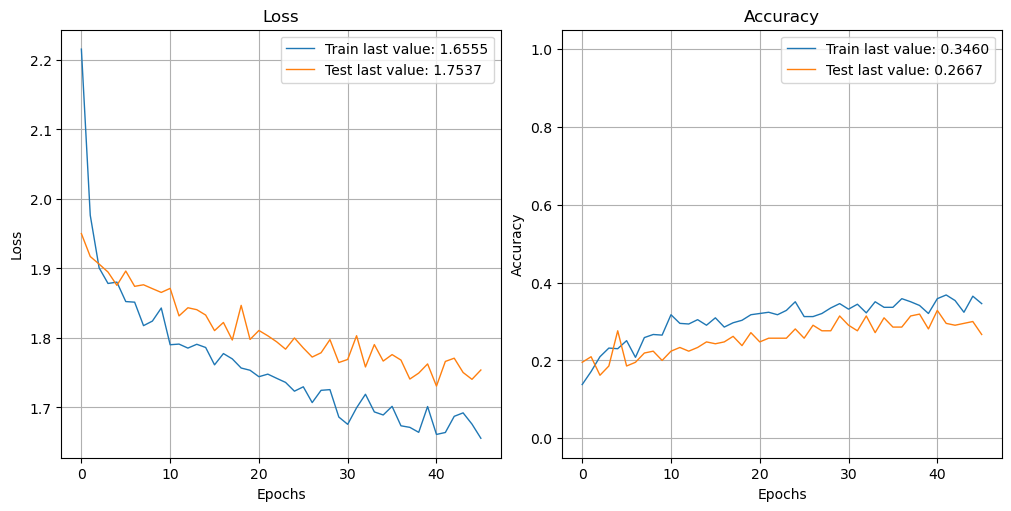

In [129]:
show_history(history5)
plot_history(history5, path="standard.png")
plt.close()

In [130]:
# On récupère nos métriques

history_dict_RN3 = history5.history
val_loss_RN3 = history_dict_RN3['val_loss']
val_acc_RN3 = history_dict_RN3['val_accuracy']
train_loss_RN3 = history_dict_RN3['loss']
train_acc_RN3 = history_dict_RN3['accuracy']

# Affichage des résultats
print("Training time:", training_time_RN3)
print("Validation accuracy:", val_acc_RN3[-1])
print("Validation loss:", val_loss_RN3[-1])
print("Train accuracy:", train_acc_RN3[-1])
print("Train loss:", train_loss_RN3[-1])

Training time: 1808.8850321769714
Validation accuracy: 0.2666666805744171
Validation loss: 1.7537466287612915
Train accuracy: 0.3460317552089691
Train loss: 1.655505895614624


In [131]:
# Nous allons stocker nos résultats dans un tableau

results = {
    'Data Augmentation' : [],
    'Model': [],
    'Validation accuracy': [],
    'Validation loss' : [], 
    'Train accuracy' : [],
    'Train Loss': [],
    'Time': []
}

# Ajouter les résultats pour le modèle VGG16
results['Model'].append('ResNet50')
results['Data Augmentation'].append('Data augmentation (dataset intégré)')
results['Validation accuracy'].append(val_acc_RN3[-1])
results['Validation loss'].append(val_loss_RN3[-1])
results['Train accuracy'].append(train_acc_RN3[-1])
results['Train Loss'].append(train_loss_RN3[-1])
results['Time'].append(training_time_RN3)

df_RN3 = pd.DataFrame(results)
display(df_RN3)

,Data Augmentation,Model,Validation accuracy,Validation loss,Train accuracy,Train Loss,Time
0,Data augmentation (dataset intégré),ResNet50,0.266667,1.753747,0.346032,1.655506,1808.885032


### c. InceptionV3

In [132]:
def create_model_fct2_Inc():
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),
    ])

    # Récupération modèle pré-entraîné
    model_base = InceptionV3(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
        data_augmentation,
        Rescaling(1./255.0),
        model_base,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(7, activation='softmax')
    ])

    # Compilation du modèle
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())

    return model

In [133]:
# Création du modèle
with tf.device('/gpu:0'): 
    model6 = create_model_fct2_Inc()

# Création du callback
model6_save_path = "./model6_best_weights.h5"
checkpoint = ModelCheckpoint(model6_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_8   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_16 (Dense)            (None, 256)               524544    
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                      

In [134]:
# Entraîner sur les données d'entraînement (X_train, y_train)
# en utilisant une validation croisée
start_time = time.time()
with tf.device('/gpu:0'): 
    history6 = model6.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)
end_time = time.time()
training_time_Inc3 = end_time - start_time
print("Le temps nécessaire pour l'entraînement est de :", training_time_Inc3, " secondes")

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 1.5758 - accuracy: 0.4603
Epoch 1: val_loss improved from inf to 0.76596, saving model to .\model6_best_weights.h5
20/20 [==============================] - 24s 974ms/step - loss: 1.5758 - accuracy: 0.4603 - val_loss: 0.7660 - val_accuracy: 0.7524
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 0.8406 - accuracy: 0.7095
Epoch 2: val_loss improved from 0.76596 to 0.56034, saving model to .\model6_best_weights.h5
20/20 [==============================] - 18s 931ms/step - loss: 0.8406 - accuracy: 0.7095 - val_loss: 0.5603 - val_accuracy: 0.8286
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 0.7167 - accuracy: 0.7651
Epoch 3: val_loss improved from 0.56034 to 0.55138, saving model to .\model6_best_weights.h5
20/20 [==============================] - 19s 947ms/step - loss: 0.7167 - accuracy: 0.7651 - val_loss: 0.5514 - val_accuracy: 0.8095
Epoch 4/50
20/20 [=============================

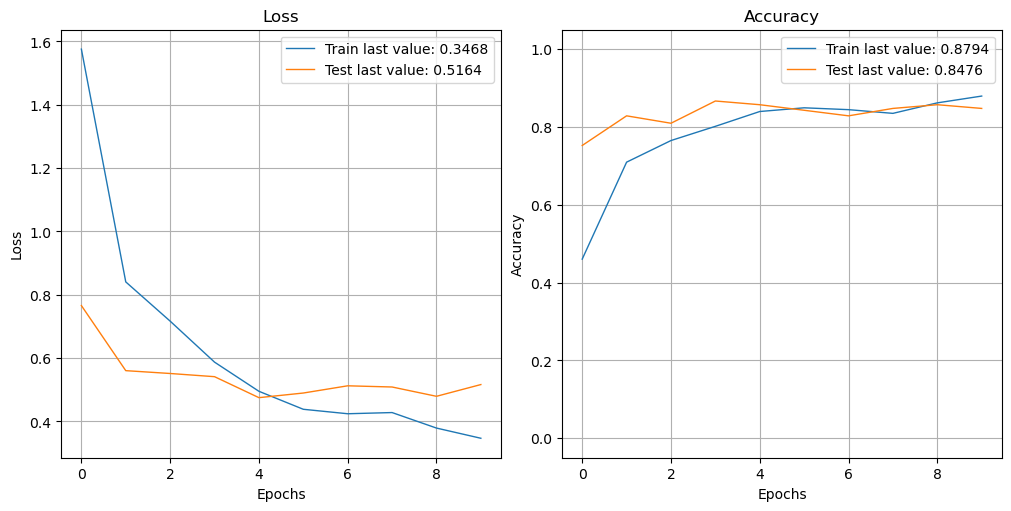

In [135]:
show_history(history6)
plot_history(history6, path="standard.png")
plt.close()

In [136]:
# On récupère nos métriques

history_dict_Inc3 = history6.history
val_loss_Inc3 = history_dict_Inc3['val_loss']
val_acc_Inc3 = history_dict_Inc3['val_accuracy']
train_loss_Inc3 = history_dict_Inc3['loss']
train_acc_Inc3 = history_dict_Inc3['accuracy']

# Affichage des résultats
print("Training time:", training_time_Inc3)
print("Validation accuracy:", val_acc_Inc3[-1])
print("Validation loss:", val_loss_Inc3[-1])
print("Train accuracy:", train_acc_Inc3[-1])
print("Train loss:", train_loss_Inc3[-1])

Training time: 191.06722402572632
Validation accuracy: 0.8476190567016602
Validation loss: 0.5164278745651245
Train accuracy: 0.879365086555481
Train loss: 0.34681931138038635


In [137]:
# Nous allons stocker nos résultats dans un tableau

results = {
    'Data Augmentation' : [],
    'Model': [],
    'Validation accuracy': [],
    'Validation loss' : [], 
    'Train accuracy' : [],
    'Train Loss': [],
    'Time': []
}

# Ajouter les résultats pour le modèle InceptionV3
results['Model'].append('InceptionV3')
results['Data Augmentation'].append('Data augmentation (dataset intégré)')
results['Validation accuracy'].append(val_acc_Inc3[-1])
results['Validation loss'].append(val_loss_Inc3[-1])
results['Train accuracy'].append(train_acc_Inc3[-1])
results['Train Loss'].append(train_loss_Inc3[-1])
results['Time'].append(training_time_Inc3)

df_Inc3 = pd.DataFrame(results)
display(df_Inc3)

,Data Augmentation,Model,Validation accuracy,Validation loss,Train accuracy,Train Loss,Time
0,Data augmentation (dataset intégré),InceptionV3,0.847619,0.516428,0.879365,0.346819,191.067224


### d. Synthèse comparative des différents modèles

In [138]:
# On récupère nos 3 dataframes que l'on va concaténer pour
# effectuer une comparaison entre les métriques calculées pour
# nos 3 modèles

df_final3 = pd.concat([df_Vgg3, df_RN3, df_Inc3], axis = 0).set_index('Model')
df_final3

,Data Augmentation,Validation accuracy,Validation loss,Train accuracy,Train Loss,Time
Model,,,,,,
VGG16,Data augmentation (dataset intégré),0.804762,0.598284,0.909524,0.325929,2177.846095
ResNet50,Data augmentation (dataset intégré),0.266667,1.753747,0.346032,1.655506,1808.885032
InceptionV3,Data augmentation (dataset intégré),0.847619,0.516428,0.879365,0.346819,191.067224


Après avoir stocké nos métriques dans un tableau, nous observons après data augmentation sur le dataset intégré au modèle que les meilleurs résultats sont obtenus avec **InceptionV3**. Le modèle ResNet50, quant à lui, n'est pas satisfaisant.

De manière générale, les meilleurs scores sont obtenus pour le modèle **InceptionV3** où nous observons également une amélioration du temps de calcul après data augmentation, mais une altération du score pour le modèle **ResNet50**. 

Néanmoins, la data augmentation ne semble pas avoir été bénéfique à nos modèles.

Nous allons regrouper nos résultats obtenus sur des graphiques pour une meilleure visualisation des scores. 

## 1.4. Représentation graphique des résultats obtenus

In [139]:
# Nous regroupons nos 3 dataframes en un seul tableau
df_results = pd.concat([df_final, df_final2, df_final3], axis = 0).reset_index()
df_results

,Model,Data Augmentation,Validation accuracy,Validation loss,Train accuracy,Train Loss,Time
0,VGG16,No Data augmentation,0.836502,0.717688,0.979670,0.064009,1143.025374
1,ResNet50,No Data augmentation,0.840304,0.684557,0.963151,0.100062,403.397775
2,InceptionV3,No Data augmentation,0.844106,0.561488,0.950445,0.152528,629.703571
3,VGG16,Data Augmentation (ImageDataGenerator),0.812977,0.569201,0.864213,0.467314,3292.387296
4,ResNet50,Data Augmentation (ImageDataGenerator),0.519084,1.414243,0.582487,1.170279,3029.167778
5,InceptionV3,Data Augmentation (ImageDataGenerator),0.847328,0.477404,0.892132,0.302265,891.787839
6,VGG16,Data augmentation (dataset intégré),0.804762,0.598284,0.909524,0.325929,2177.846095
7,ResNet50,Data augmentation (dataset intégré),0.266667,1.753747,0.346032,1.655506,1808.885032
8,InceptionV3,Data augmentation (dataset intégré),0.847619,0.516428,0.879365,0.346819,191.067224


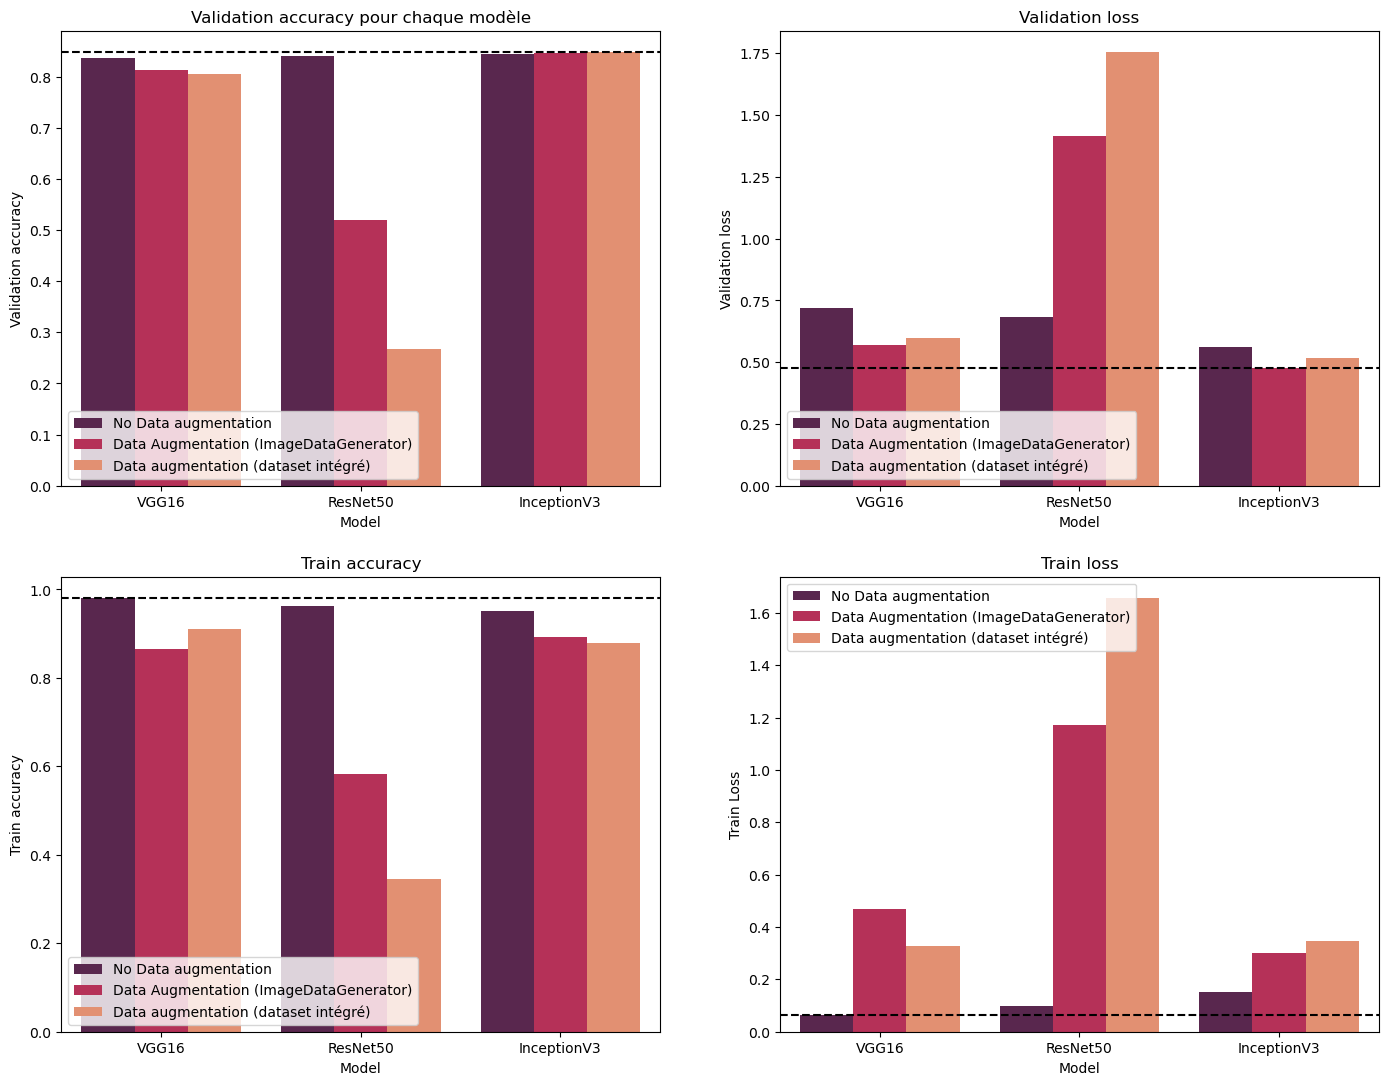

In [140]:
#Représentation graphique

fig,axs=plt.subplots(2,2,figsize=(17,13))

# Validation accuracy
y_max_valacc = max(df_results['Validation accuracy'])
subset = df_results[['Model', 'Data Augmentation', 'Validation accuracy']]
sns.barplot(data=subset, x='Model', y='Validation accuracy', ax=axs[0, 0], hue = 'Data Augmentation', palette = 'rocket')
# for i, value in enumerate(subset.iloc[:, 1]):
#     axs[0, 0].annotate(round(value, 3), xy=(i, value), ha='center', va='bottom')
axs[0, 0].set_title('Validation accuracy pour chaque modèle')
axs[0, 0].set_xticklabels(axs[0, 0].get_xticklabels())
axs[0, 0].legend(loc='lower left')
axs[0, 0].axhline(y=y_max_valacc, linestyle='--', color='k')

# Validation loss
y_min_valoss = min(df_results['Validation loss'])
subset = df_results[['Model', 'Validation loss', 'Data Augmentation']]
sns.barplot(data=subset, x='Model', y='Validation loss', ax=axs[0, 1], hue = 'Data Augmentation', palette = 'rocket')
# for i, value in enumerate(subset.iloc[:, 1]):
#     axs[0, 1].annotate(round(value, 3), xy=(i, value), ha='center', va='bottom')
axs[0, 1].set_title('Validation loss')
axs[0, 1].set_xticklabels(axs[0, 1].get_xticklabels())
axs[0, 1].legend(loc = 'lower left')
axs[0, 1].axhline(y=y_min_valoss, linestyle='--', color='k')

# Train accuracy
y_max_trainacc = max(df_results['Train accuracy'])
subset = df_results[['Model', 'Train accuracy', 'Data Augmentation']]
sns.barplot(data=subset, x='Model', y='Train accuracy', ax=axs[1, 0], hue = 'Data Augmentation', palette = 'rocket')
# for i, value in enumerate(subset.iloc[:, 1]):
#     axs[1, 0].annotate(round(value, 3), xy=(i, value), ha='center', va='bottom')
axs[1, 0].set_title('Train accuracy')
axs[1, 0].set_xticklabels(axs[1, 0].get_xticklabels())
axs[1, 0].legend(loc = 'lower left')
axs[1, 0].axhline(y=y_max_trainacc, linestyle='--', color='k')

# Train Loss
y_min_trainloss = min(df_results['Train Loss'])
subset = df_results[['Model', 'Train Loss', 'Data Augmentation']]
sns.barplot(data=subset, x='Model', y='Train Loss', ax=axs[1, 1], hue = 'Data Augmentation', palette = 'rocket')
# for i, value in enumerate(subset.iloc[:, 1]):
#     axs[1, 1].annotate(round(value, 3), xy=(i, value), ha='center', va='bottom')
axs[1, 1].set_title('Train loss')
axs[1, 1].set_xticklabels(axs[1, 1].get_xticklabels())
axs[1, 1].legend(loc = 'upper left')
axs[1, 1].axhline(y=y_min_trainloss, linestyle='--', color='k')

plt.show()

Le graphique illustre les résultats obtenus où l'on peut voir que les valeurs de précision les plus élevées pour les données de validation sont atteintes par le modèle **InceptionV3**, il en est de même pour les valeurs de perte où les plus faibles sont également atteintes par ce modèle particulièrement <u>*lors de la data augmentation*</u> par dataset intégré au modèle. Néanmoins, les valeurs de précision les plus élevées pour les données d'entrainement sont atteintes pat le modèle **VGG16**, il en est de même pour les valeurs de perte les plus faibles atteintes par ce modèle en <u>*absence de data augmentation*</u>.  


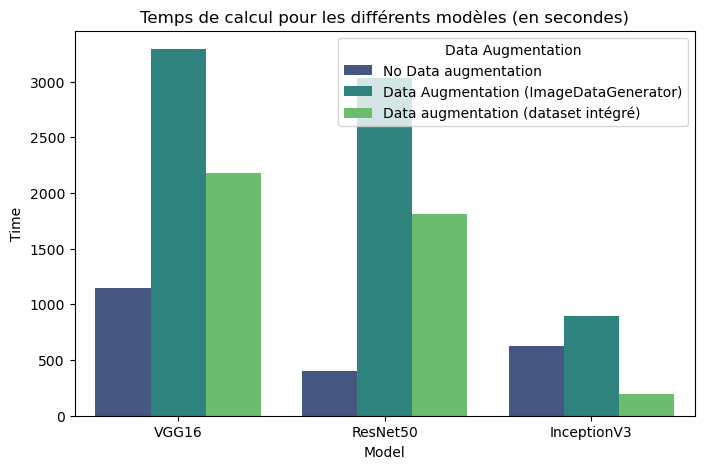

In [141]:
# Graphique représentant le temps de calcul pour chaque modèle
plt.figure(figsize=(8, 5))
sns.barplot(data = df_results, x = 'Model', y = 'Time', hue = 'Data Augmentation', palette = 'viridis')
plt.title('Temps de calcul pour les différents modèles (en secondes)')
plt.show()

On observe que le modèle dont le temps de calcul est le plus élevé est VGG16. InceptionV3 est le modèle dont le temps de calcul est le plus faible est InceptionV3. 

# 2. Classification données texte et image combinées

La dernière étape de notre modélisation consiste à combiner les deux extractions de features (texte et image) dans une seule modélisation. Nous avons, au préalable, choisi de garder la combinaison des features extraites par BERT pour les données textuelles et par ResNet50 pour les données images.

Nous allons maintenant tester plusieurs algorithmes de classification supervisée et calculer le score de précision sur les données de test, afin d'évaluer la performance de ces algorithmes pour notre jeu de données. 

In [142]:
# On récupère nos données combinées enregistrées

df_combined = pd.read_csv('donnees_combinees.csv')
df_combined

,0,1,2,3,4,5,6,7,8,9,...,2809,2810,2811,2812,2813,2814,2815,label,classes,image
0,0.200532,-0.205197,0.718838,-0.039785,0.536180,0.252377,0.075956,0.072761,-0.095616,-0.352870,...,0.004406,1.604243,0.043518,0.350531,0.343850,0.000000,2.165368,6,Watches,009099b1f6e1e8f893ec29a7023153c4.jpg
1,0.148335,-0.078400,0.482108,0.107813,0.193846,0.023847,0.169878,-0.041152,-0.014009,-0.176780,...,0.000000,0.383919,0.720446,0.088955,1.474887,1.040611,1.635146,5,Kitchen & Dining,0096e89cc25a8b96fb9808716406fe94.jpg
2,0.125866,-0.148298,0.577522,0.018957,0.247185,-0.053283,-0.170143,0.165906,-0.146471,-0.198538,...,0.000000,0.321536,0.036855,1.523284,0.539581,0.000000,0.163918,4,Home Furnishing,00cbbc837d340fa163d11e169fbdb952.jpg
3,0.221357,-0.015224,0.635228,0.155166,0.314898,-0.232043,-0.184382,0.231620,-0.140047,0.035541,...,0.000000,0.987284,0.211744,0.058020,0.115298,0.828230,0.776003,1,Beauty and Personal Care,00d84a518e0550612fcfcba3b02b6255.jpg
4,0.267699,-0.005922,0.637282,-0.057764,0.332293,-0.412970,-0.129525,0.212769,0.020182,-0.111424,...,0.000000,0.000000,0.000000,0.160530,0.779795,0.000000,0.175765,2,Computers,00e966a5049a262cfc72e6bbf68b80e7.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,0.077468,-0.016837,0.565416,-0.061591,0.453999,-0.157798,-0.058580,-0.036870,-0.002849,-0.202241,...,0.039449,0.129278,0.041068,0.002304,1.290403,0.528177,0.217817,5,Kitchen & Dining,feefbdff924dd6b7cc266449c9a36d69.jpg
1046,-0.068411,0.044751,0.782705,-0.076141,0.388394,-0.182646,-0.062199,0.052043,0.141789,-0.451822,...,0.035209,0.637854,0.038262,0.311180,0.037905,0.064269,0.586391,4,Home Furnishing,ff24511994fc459d04145231c8876d6c.jpg
1047,0.024530,-0.034610,0.385686,0.140902,0.122256,0.019029,-0.201765,0.401635,-0.047594,0.066574,...,0.343134,0.106265,0.637907,0.000000,0.132733,0.553587,0.019971,5,Kitchen & Dining,ffbf3794aa8cb6bb8d3f313d0a549a09.jpg
1048,-0.096320,-0.067955,0.418710,0.186750,0.008486,-0.005916,0.006568,0.211165,0.176779,-0.085504,...,0.128561,0.000000,0.083252,0.598811,0.787799,0.000000,0.069778,4,Home Furnishing,ffc2e1fc7c886ec09a331040ada038aa.jpg


## 2.1. SVM (Support Vector Machines)

In [143]:
# Mise en place d'un algorithme de classification supervisée

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Séparation des features et labels
X = df_combined.drop(['label', 'image', 'classes'], axis=1)
y = df_combined['label']

# Divisez vos données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Créez un objet SVM
svm_model = SVC()

# Entraînez le modèle SVM sur les données d'entraînement
svm_model.fit(X_train, y_train)

# Prédisez les étiquettes pour les données de test
y_pred_svm = svm_model.predict(X_test)

# Évaluez la précision du modèle
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Accuracy SVM:", accuracy_svm)

Accuracy SVM: 0.870722433460076


In [144]:
# Optimisation des hyperparamètres

from sklearn.model_selection import GridSearchCV

# Créez un objet SVM
svm_model = SVC()

# Hyperparamètres à optimiser
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': [0.1, 0.5, 1]}

# GridSearchCV pour trouver les meilleurs hyperparamètres
grid_search = GridSearchCV(svm_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Meilleurs hyperparamètres trouvés
best_params = grid_search.best_params_
print("Meilleurs hyperparamètres :", best_params)

# Utilisation du modèle avec les meilleurs hyperparamètres
# pour les prédictions des données test
best_model = grid_search.best_estimator_
y_pred_svm = best_model.predict(X_test)

# Évaluez la précision du modèle
accuracy_svm_opt = accuracy_score(y_test, y_pred_svm)
print("Accuracy SVM (avec meilleurs hyperparamètres) :", accuracy_svm_opt)

Meilleurs hyperparamètres : {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}
Accuracy SVM (avec meilleurs hyperparamètres) : 0.8517110266159695


Les hyperparamètres optimisés ne semblent pas forcément donner une meilleure accuracy, donc nous allons laisser les paramètres par défaut. 

In [145]:
# On crée un tableau pour stocker nos scores Accuracy

results_acc = {
    'Model' : [],
    'Accuracy Score' : []
}

# On ajoute nos résultats
results_acc['Model'].append('SVM')
results_acc['Accuracy Score'].append(accuracy_svm)

# On crée un dataframe
df_svm = pd.DataFrame(results_acc)
df_svm

,Model,Accuracy Score
0,SVM,0.870722


## 2.2. Random Forest

In [146]:
from sklearn.ensemble import RandomForestClassifier

# Créez un objet Random Forest Classifier
rf_model = RandomForestClassifier()

# Entraînez le modèle Random Forest sur les données d'entraînement
rf_model.fit(X_train, y_train)

# Prédisez les étiquettes pour les données de test
y_pred_rf = rf_model.predict(X_test)

# Évaluez la précision du modèle
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Accuracy Random Forest:", accuracy_rf)

Accuracy Random Forest: 0.8517110266159695


In [147]:
# Optimisation hyperparamètres

rf_model = RandomForestClassifier()

param_grid = {
'n_estimators': [100, 200, 300],
'max_depth': [None, 5, 10],
'min_samples_split': [2, 5, 10],
'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(rf_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Meilleurs hyperparamètres :", best_params)

best_model = grid_search.best_estimator_
y_pred_rf = best_model.predict(X_test)

accuracy_rf_opt = accuracy_score(y_test, y_pred_rf)
print("Accuracy Random Forest (avec meilleurs hyperparamètres) :", accuracy_rf_opt)

Meilleurs hyperparamètres : {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Accuracy Random Forest (avec meilleurs hyperparamètres) : 0.8631178707224335


In [148]:
# On crée un tableau pour stocker nos scores Accuracy

results_acc = {
    'Model' : [],
    'Accuracy Score' : []
}

# On ajoute nos résultats
results_acc['Model'].append('Random Forest')
results_acc['Accuracy Score'].append(accuracy_rf)

# On crée un dataframe
df_rf = pd.DataFrame(results_acc)
df_rf

,Model,Accuracy Score
0,Random Forest,0.851711


## 2.3. Logistic Regression

In [149]:
from sklearn.linear_model import LogisticRegression

# Création objet Logistic Regression
lr_model = LogisticRegression()

# Entraînez le modèle Random Forest sur les données d'entraînement
lr_model.fit(X_train, y_train)

# Prédisez les étiquettes pour les données de test
y_pred_lr = lr_model.predict(X_test)

# Évaluez la précision du modèle
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print("Accuracy Logistic Regression:", accuracy_lr)

Accuracy Logistic Regression: 0.870722433460076


In [150]:
# On crée un tableau pour stocker nos scores Accuracy

results_acc = {
    'Model' : [],
    'Accuracy Score' : []
}

# On ajoute nos résultats
results_acc['Model'].append('Logistic Regression')
results_acc['Accuracy Score'].append(accuracy_lr)

# On crée un dataframe
df_lr = pd.DataFrame(results_acc)
df_lr

,Model,Accuracy Score
0,Logistic Regression,0.870722


## 2.4. KNN 

In [151]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()

knn_model.fit(X_train, y_train)

y_pred_knn = knn_model.predict(X_test)

accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("Accuracy KNN:", accuracy_knn)

Accuracy KNN: 0.8326996197718631


In [152]:
# On crée un tableau pour stocker nos scores Accuracy

results_acc = {
    'Model' : [],
    'Accuracy Score' : []
}

# On ajoute nos résultats
results_acc['Model'].append('KNN')
results_acc['Accuracy Score'].append(accuracy_knn)

# On crée un dataframe
df_knn = pd.DataFrame(results_acc)
df_knn

,Model,Accuracy Score
0,KNN,0.8327


## 2.5. XGBoost

In [154]:
pip install xgboost

     --------------------------------------- 70.9/70.9 MB 11.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [155]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("Accuracy XGBoost:", accuracy_xgb)

Accuracy XGBoost: 0.8403041825095057


In [156]:
# On crée un tableau pour stocker nos scores Accuracy

results_acc = {
    'Model' : [],
    'Accuracy Score' : []
}

# On ajoute nos résultats
results_acc['Model'].append('XGBoost')
results_acc['Accuracy Score'].append(accuracy_xgb)

# On crée un dataframe
df_xgb = pd.DataFrame(results_acc)
df_xgb

,Model,Accuracy Score
0,XGBoost,0.840304


## 2.6. Gradient Boosting Regressor

In [157]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print("Accuracy Gradient Boosting:", accuracy_gb)

Accuracy Gradient Boosting: 0.8365019011406845


In [158]:
# On crée un tableau pour stocker nos scores Accuracy

results_acc = {
    'Model' : [],
    'Accuracy Score' : []
}

# On ajoute nos résultats
results_acc['Model'].append('Gradient Boosting Reg')
results_acc['Accuracy Score'].append(accuracy_gb)

# On crée un dataframe
df_gb = pd.DataFrame(results_acc)
df_gb

,Model,Accuracy Score
0,Gradient Boosting Reg,0.836502


## 2.7. Visualisation graphique

In [159]:
# Regroupement des résultats dans un tableau

df_acc = pd.concat([df_svm, df_rf, df_lr, df_knn, df_xgb, df_gb], axis=0)
df_acc['Accuracy Score'] = round(df_acc['Accuracy Score'], 3)

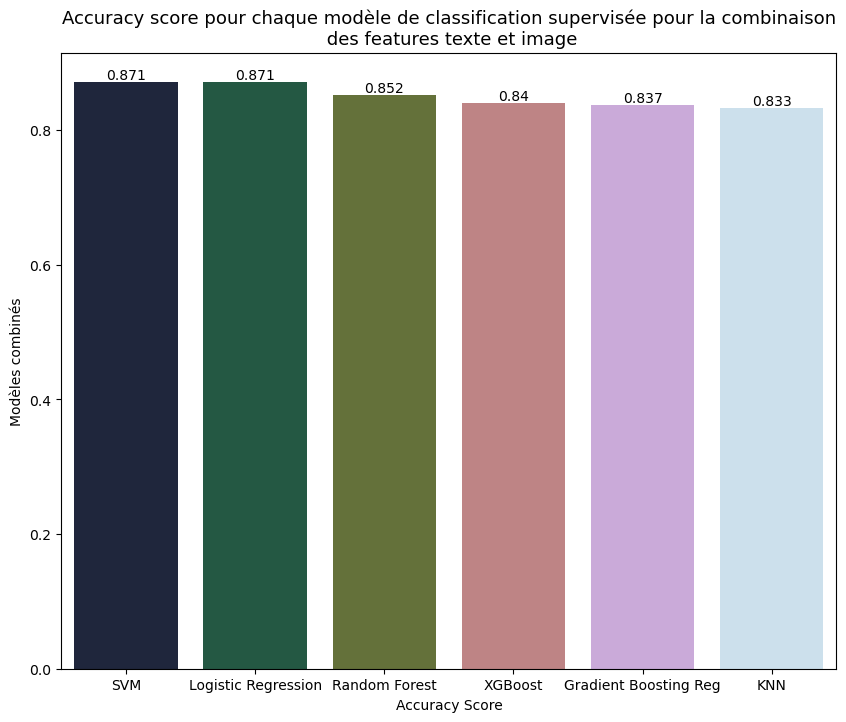

In [160]:
# Visualisation graphique des résultats

palette = sns.color_palette("cubehelix", len(df_acc))

# Tri des données par Accuracy score
df_acc_sorted = df_acc.sort_values('Accuracy Score', ascending=False)

# Tracé du graphique en utilisant la palette de couleurs personnalisée
plt.figure(figsize=(10, 8))
ax = sns.barplot(data=df_acc_sorted, x='Model', y='Accuracy Score', palette=palette)
plt.title('Accuracy score pour chaque modèle de classification supervisée pour la combinaison\n des features texte et image', size=13)
plt.ylabel('Modèles combinés')
plt.xlabel('Accuracy Score')

for i in ax.containers:
    ax.bar_label(i,)

plt.show()

Les meilleurs scores d'accuracy sont obtenus pour le modèle SVM et Logistic Regression. 

## 2.8. Matrice de confusion

In [161]:
# On crée la matrice de confusion pour le modèle SVM
from sklearn.metrics import confusion_matrix

# Calculer la matrice de confusion
confusion = confusion_matrix(y_test, y_pred_svm)
print("Matrice de confusion :")
print(confusion)

Matrice de confusion :
[[26  0  1  7  6  1  0]
 [ 3 35  0  1  0  1  0]
 [ 0  0 34  1  0  1  0]
 [ 0  1  0 26  0  2  0]
 [ 5  0  0  1 31  0  0]
 [ 0  5  1  1  0 31  0]
 [ 0  1  0  0  0  0 41]]


In [162]:
# On reprend notre fonction

def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = [0, 1, 2, 3, 4, 5, 6]
    print ("Correspondance des clusters : ", corresp)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

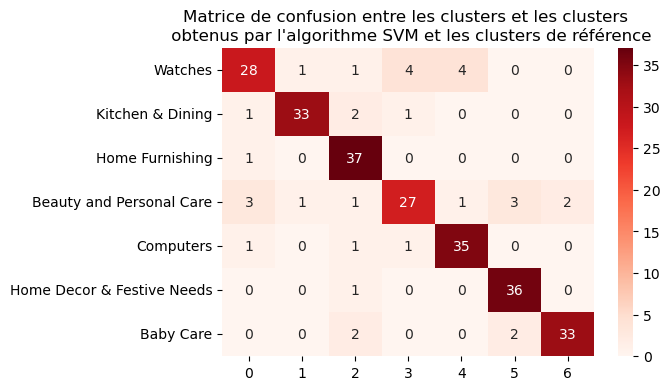

In [163]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_categ],
                     columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
plt.title('Matrice de confusion entre les clusters et les clusters \n obtenus par l\'algorithme SVM et les clusters de référence')
sns.heatmap(df_cm, annot=True, cmap="Reds")
plt.show()

La matrice de confusion obtenue montre globalement que le nombre de bonnes prédictions est assez élevé pour chaque catégorie, à quelques différences près. La catégorie "Baby Care" semble la mieux prédite, deux produits n'ont cependant pas l'air d'appartenit à la bonne catégorie. La catégorie "Watches" montre 8 produits confondus avec la catégorie "Computers" et 5 produits confondus avec la catégorie "Beauty and Personal Care". 